In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from tqdm import tqdm

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")

raw_file_folders = os.listdir(raw_file_path)

folder_path = os.path.join(raw_file_path, raw_file_folders[0])

In [2]:
def register_add_time_property(register):
    register['STD_DD']=pd.to_datetime(register.STD_DD, format='%Y%m%d')
    
    register['year'] = register['STD_DD'].dt.year.values
    register['month'] = register['STD_DD'].dt.month.values
    register['weekofyear'] = register['STD_DD'].dt.weekofyear.values
    register['dayofweek'] = register['STD_DD'].dt.dayofweek.values

    register['weekday'] = np.where(register.dayofweek<5,'평일','주말')
    
    return register

In [346]:
register.head(2)

STD_DD  GU_CD  DONG_CD  MCT_CAT_CD SEX_CD  AGE_CD  USE_CNT  USE_AMT  \
0  2019-02-01    110      517          10      F      25       11      595   
1  2019-02-01    110      517          10      F      50        5      243   

   GU_NM HDONG_NM  year  month  weekofyear  dayofweek weekday MCT_CAT_NM  
0  대구 중구      동인동  2019      2           5          4      평일         숙박  
1  대구 중구      동인동  2019      2           5          4      평일         숙박

In [3]:
def convert_code_to_name_register(register):
    df = register
    df['region_code'] = df.GU_CD.astype(str)+df.DONG_CD.astype(str)
    
    with open(os.path.join(pickle_file_path, 'card_code_to_name_dict.pickle'), 'rb') as f:
        card_code_to_name_dict = pickle.load(f)
        
    cat_dict = {10 : '숙박',
                20 : '레저용품',
                21 : '레저업소',
                22 : '문화취미',
                30 : '가구',
                31 : '전기',
                32 : '주방용구',
                33 : '연료판매',
                34 : '광학제품',
                35 : '가전',
                40 : '유통업',
                42 : '의복',
                43 : '직물',
                44 : '신변잡화',
                50 : '서적문구',
                52 : '사무통신',
                60 : '자동차판매',
                62 : '자동차 정비',
                70 : '의료기관',
                71 : '보건위생',
                80 : '요식업소',
                81 : '음료식품',
                92 : '수리서비스'}
    
    df['GU_NM'] = df.region_code.map(card_code_to_name_dict.get('구명'))
    df['HDONG_NM'] = df.region_code.map(card_code_to_name_dict.get('행정동명'))
    df['MCT_CAT_NM'] = df.MCT_CAT_CD.map(cat_dict)
    
    return df

In [4]:
sk_files = [file for file in os.listdir(csv_file_path) if file.startswith('SK_melted')]
card_files = [file for file in os.listdir(csv_file_path) if file.startswith('카드')]

In [5]:
df_list_card = []

for file_name in card_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_card.append(df)

In [6]:
df_list_sk = []

for file_name in sk_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_sk.append(df)

In [7]:
register = df_list_card[1].drop(df_list_card[1].columns[0], axis=1)

register = convert_code_to_name_register(register)
register = register_add_time_property(register)

register.head()

STD_DD  GU_CD  DONG_CD  MCT_CAT_CD SEX_CD  AGE_CD  USE_CNT  USE_AMT  \
0 2019-02-01    110      517          10      F      25       11      595   
1 2019-02-01    110      517          10      F      50        5      243   
2 2019-02-01    110      517          10      F      55        5       27   
3 2019-02-01    110      517          10      M      20       11      243   
4 2019-02-01    110      517          10      M      25       11      433   

  region_code  GU_NM HDONG_NM MCT_CAT_NM  year  month  weekofyear  dayofweek  \
0      110517  대구 중구      동인동         숙박  2019      2           5          4   
1      110517  대구 중구      동인동         숙박  2019      2           5          4   
2      110517  대구 중구      동인동         숙박  2019      2           5          4   
3      110517  대구 중구      동인동         숙박  2019      2           5          4   
4      110517  대구 중구      동인동         숙박  2019      2           5          4   

  weekday  
0      평일  
1      평일  
2      평일  
3      평일  
4      평일

In [8]:
fp_age= df_list_sk[0]
fp_time = df_list_sk[1]

### 행정동별 Risk Index

* RISK INDEX
 
    * 코로나기간 (3월최저점 ~ +7일) - (2월최고점 ~ +7일)  
    => 기간 1주일로 잡은이유 
        : 카드소비 및 유통(GS편의점)소비에서 모두 일주일마다 소비의 패턴이 유사함을 볼 수 있었음. 따라서 1주일을 기간의 unit으로 설정하였고 기간이 길어질수록, 코로나 상황이 가장심했던 기간이후 소비가 회복되는 시점을 포함하는 경우가 많아져 1주일을 기준으로 잡게 됨
    * 비교구간 (2019년 2월,3월)
    => 기간 1달 : 평상시 상황을 최대한 고려하기 위해 기간을 좀 더 넓게 잡음
    
        * 유동인구
        * 카드소비액
            * 불규칙하게 소비액이 급등하는 날이 있었고, 이에 대한 타당한 이유를 찾지 못해 각 기간동안 하위5%, 상위5% 소비액을 제외한후 평균소비액을 구함. 평균소비액을 사용한 이유는 2월과 3월의 일수가 달라 합으로 계산했을시 왜곡된 결과가 나올수 있다고 생각했기 때문         
        * 카드소비횟수
            * 카드소비액과 동일한 방식

In [131]:
def get_minNmax_fp_date(df):
    
    #설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    df_feb_2019 = df.query('year==2019 & month==2 & STD_YMD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_YMD'])['flow_counts'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_YMD'])['flow_counts'].sum())
    
    return mn2019,mx2019,mn2020,mx2020

In [138]:
def risk_index_fp(df, covid_weight=.6):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2019,max2019,min2020,max2020 = get_minNmax_fp_date(tmp_df)
        
        tmp_df = tmp_df.groupby('STD_YMD')['flow_counts'].sum().reset_index()
        
        # min_date_index_2019 = tmp_df[tmp_df.STD_YMD == min2019].index.values[0]
        # max_date_index_2019 = tmp_df[tmp_df.STD_YMD == max2019].index.values[0]
        
        min_date_index_2020 = tmp_df[tmp_df.STD_YMD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_YMD == max2020].index.values[0]
        
        # fp_feb_2019 = tmp_df.iloc[min_date_index_2019:min_date_index_2019+7,1].sum()
        # fp_mar_2019 = tmp_df.iloc[max_date_index_2019:max_date_index_2019+7,1].sum()
        
        fp_feb_2019 = tmp_df.iloc[:28,1].mean()
        fp_mar_2019 = tmp_df.iloc[28:28+31,1].mean()
        
        fp_feb_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,1].sum()
        fp_mar_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,1].sum()
        
        r1 = (fp_mar_2019 - fp_feb_2019)/fp_feb_2019
        r2 = (fp_mar_2020 - fp_feb_2020)/fp_feb_2020
        
        risk = (r2*covid_weight)-(r1*(1-covid_weight))
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [133]:
def plot_fp_risk(df, dong):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_YMD'] = tmp_df.STD_YMD.astype(str)
    
    mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_YMD')['flow_counts'].sum().mean()
    mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_YMD')['flow_counts'].sum().mean()
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_YMD')['flow_counts'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_YMD')['flow_counts'].sum().reset_index(),
        x = 'STD_YMD',
        y = 'flow_counts',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

In [139]:
risk_fp = risk_index_fp(fp_time)
risk_fp

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 28.64it/s]


{'고산1동': -0.1555006818383986,
 '고산2동': -0.1430199755482137,
 '고산3동': -0.11913701275583866,
 '공릉1동': -0.11197610462581792,
 '공릉2동': -0.14437145953447744,
 '광희동': -0.2012490020863103,
 '남산1동': -0.21380382421042435,
 '남산2동': -0.26905046500624746,
 '남산3동': -0.16853324596811733,
 '남산4동': -0.11173364855579998,
 '다산동': -0.1929732498186494,
 '대봉1동': -0.1447169341265035,
 '대봉2동': -0.19778558737501944,
 '대신동': -0.24508918952956532,
 '동인동': -0.21419572857335062,
 '동화동': -0.31558457982766774,
 '두산동': -0.13991587362206956,
 '만촌1동': -0.1716253097645066,
 '만촌2동': -0.2376482159411944,
 '만촌3동': -0.14027268634651915,
 '명동': -0.21490202167678954,
 '범물1동': -0.13593067500550812,
 '범물2동': -0.1062505019380738,
 '범어1동': -0.1774692093372046,
 '범어2동': -0.23535132000562653,
 '범어3동': -0.21021009494731002,
 '범어4동': -0.31501960487282715,
 '삼덕동': -0.25069405381124527,
 '상계10동': -0.10320485720891735,
 '상계1동': -0.11591486088432587,
 '상계2동': -0.17158323497417977,
 '상계3.4동': -0.035867621911571855,
 '상계5동': -0.0733055200

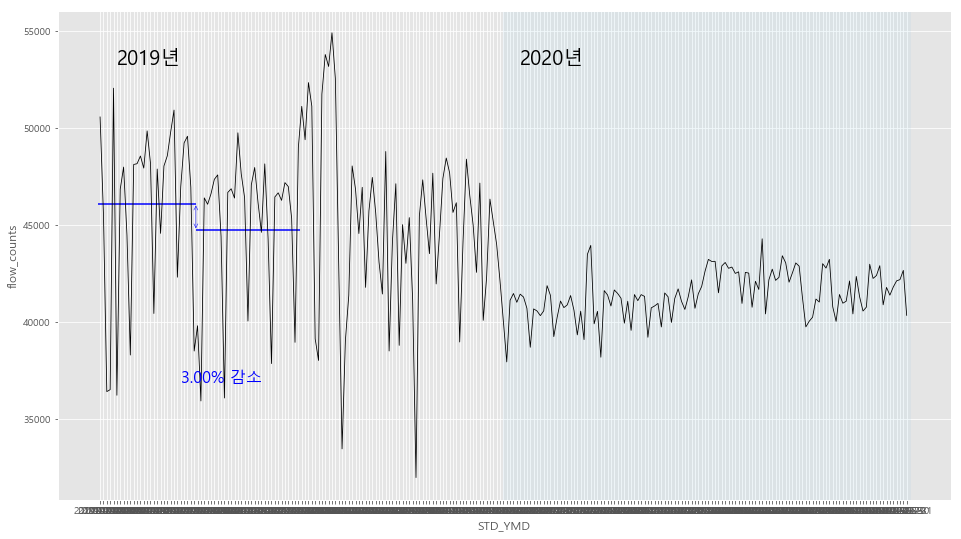

In [141]:
plot_fp_risk(fp_time,'월계2동')

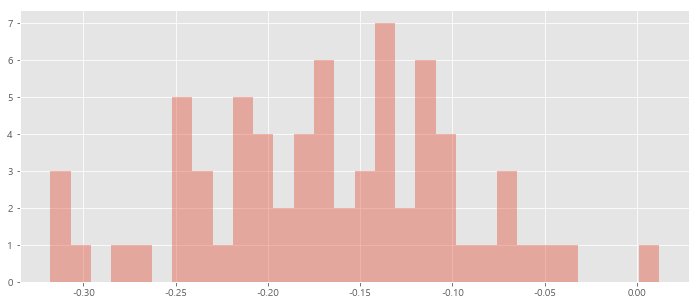

In [140]:
plt.figure(figsize=(12,5))
sns.distplot([v for i,v in risk_fp.items()], kde=False, bins=30)

In [9]:
def get_minNmax_cardAMT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_DD'])['USE_AMT'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_DD'])['USE_AMT'].sum())
    
    return mn2020,mx2020

In [10]:
# outlier제거하는 방향으로 해봐야할듯

def risk_index_cardAMT(df):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2020,max2020 = get_minNmax_cardAMT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_AMT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardAMT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardAMT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardAMT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardAMT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        #
        cardAMT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        cardAMT_mar_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardAMT_mar_2019 - mean_cardAMT_feb_2019)/mean_cardAMT_feb_2019
        r2 = (cardAMT_mar_2020 - cardAMT_feb_2020)/cardAMT_feb_2020
        
        risk = np.sqrt((r1+1)*(r2+1))-1
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [17]:
def plot_cardAMT_risk(df, dong):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.9]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.9]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_AMT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_AMT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_AMT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

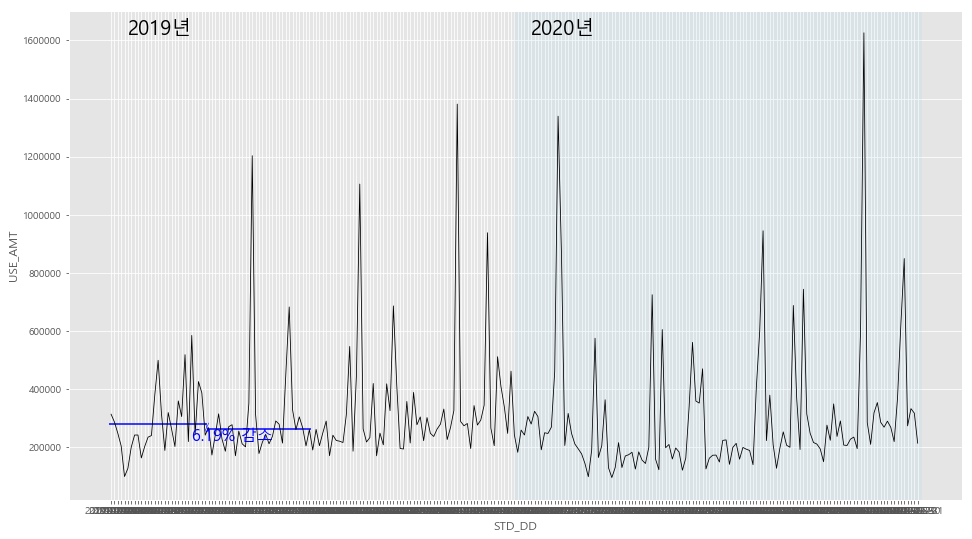

In [421]:
plot_cardAMT_risk(register, '황금2동')

In [18]:
risk_index_cardAMT(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:11<00:00,  5.96it/s]


{'고산1동': 0.25605286181069786,
 '고산2동': 0.1634233536181371,
 '고산3동': 0.08454685240547821,
 '공릉1동': 0.06373740307522113,
 '공릉2동': 0.1722143018329092,
 '광희동': 0.18971472648479404,
 '남산1동': 0.2524531579599303,
 '남산2동': 0.5827420549240403,
 '남산3동': 0.5335397569433866,
 '남산4동': 0.02782308012123247,
 '다산동': 0.03003283497807585,
 '대봉1동': 0.47536611122961636,
 '대봉2동': 0.8295327738148255,
 '대신동': 0.678052844612415,
 '동인동': 0.4112888381449151,
 '동화동': 0.09388659349167283,
 '두산동': 0.24996758047845713,
 '만촌1동': 0.2431832552371347,
 '만촌2동': 0.6384708411754116,
 '만촌3동': 0.22463271785293903,
 '명동': 0.15842257931861958,
 '범물1동': 0.2831872082365501,
 '범물2동': 0.03487457776307479,
 '범어1동': 0.35235043193936955,
 '범어2동': 0.5325614184311267,
 '범어3동': 0.31740885787586093,
 '범어4동': 0.23003390137004853,
 '삼덕동': 0.42274622049771415,
 '상계10동': 0.11634341619719013,
 '상계1동': 0.048202904097483845,
 '상계2동': 0.15676439622610205,
 '상계3.4동': 0.04240825942335191,
 '상계5동': -0.014008578754701961,
 '상계6.7동': 0.1472086431141

In [13]:
risk_index_card = risk_index_cardAMT(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:11<00:00,  5.84it/s]


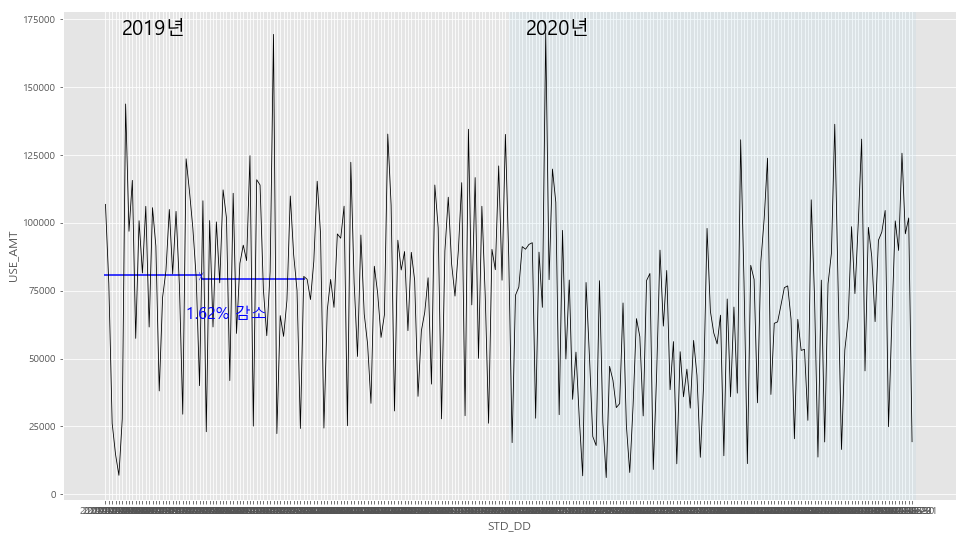

In [15]:
plot_cardAMT_risk(register, '남산2동')

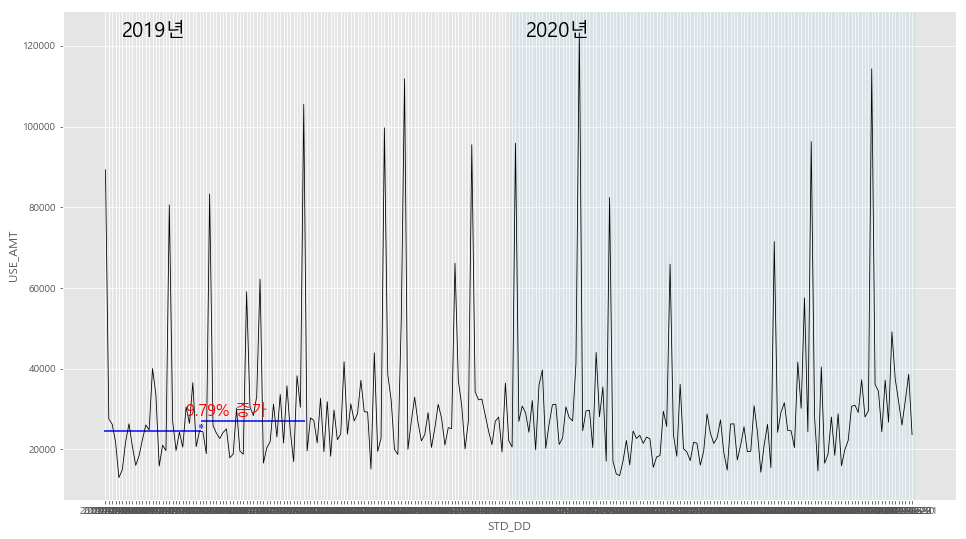

In [16]:
plot_cardAMT_risk(register, '남산3동')

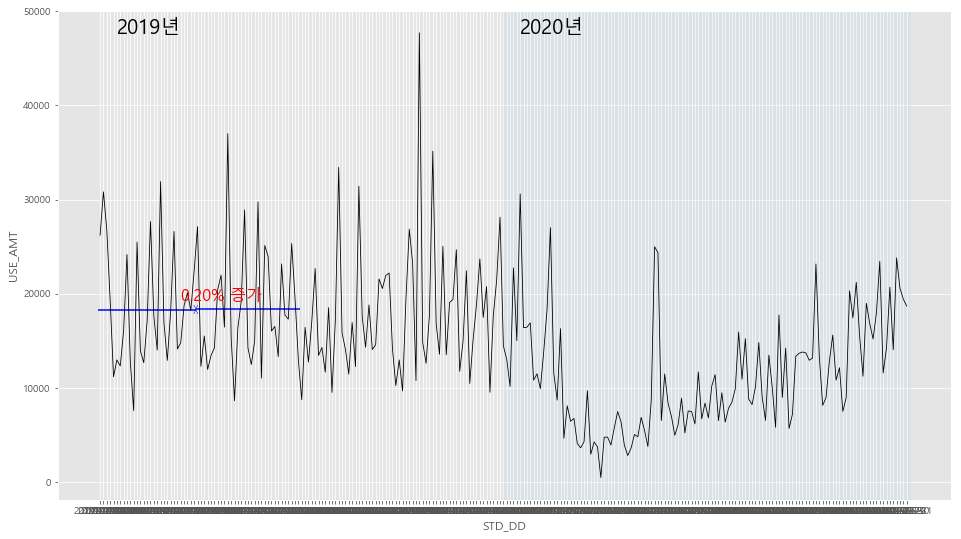

In [14]:
plot_cardAMT_risk(register, '대봉2동')

215

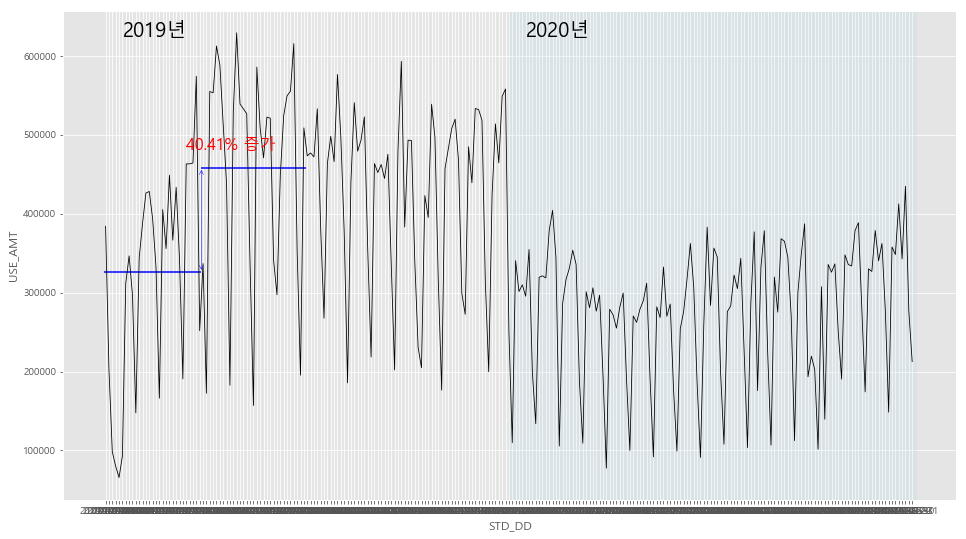

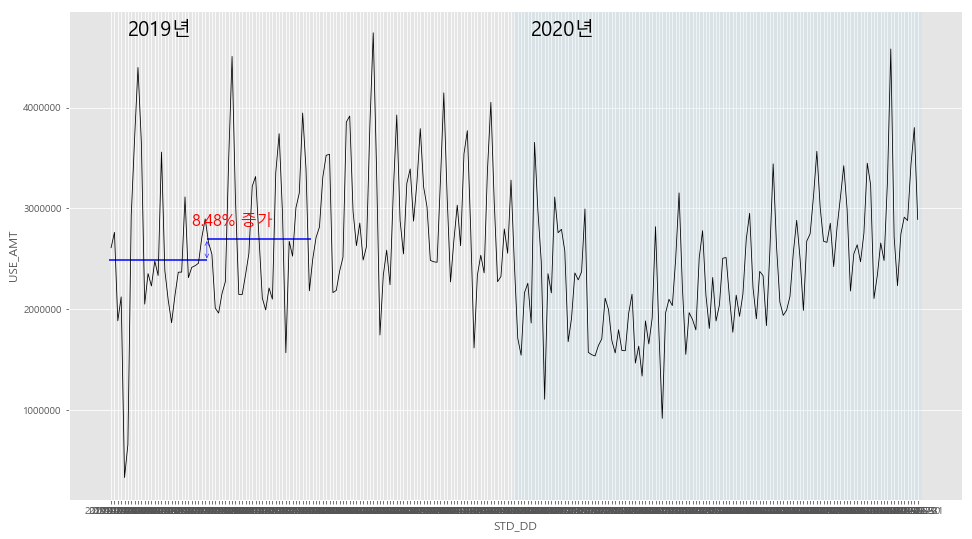

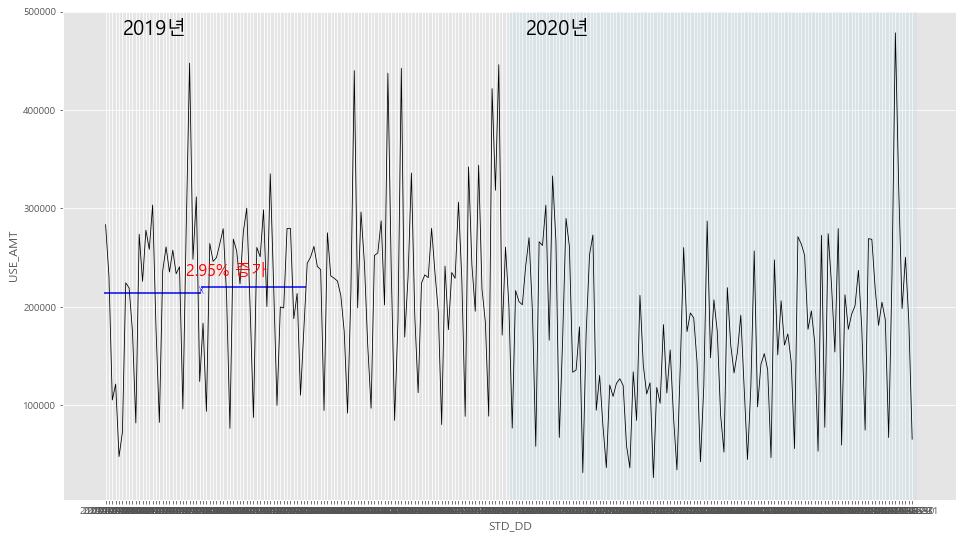

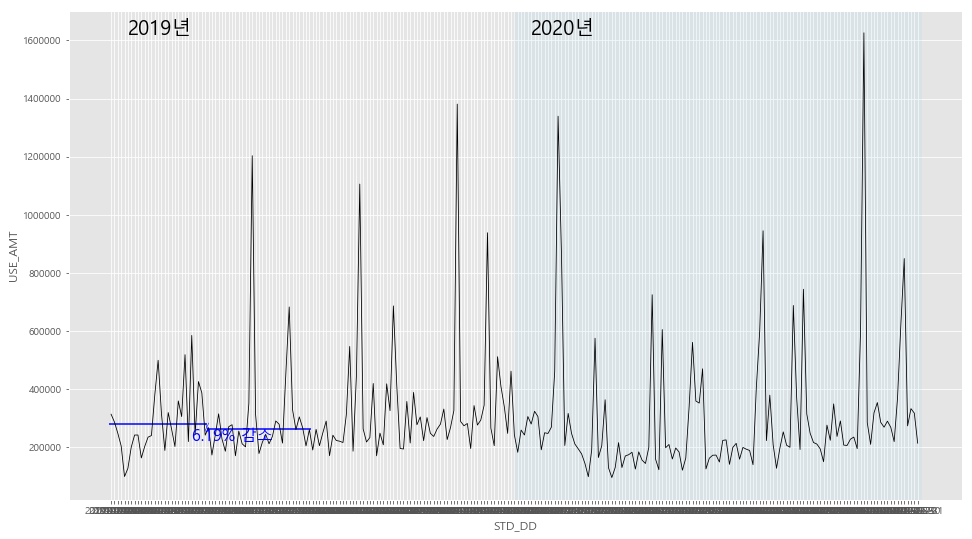

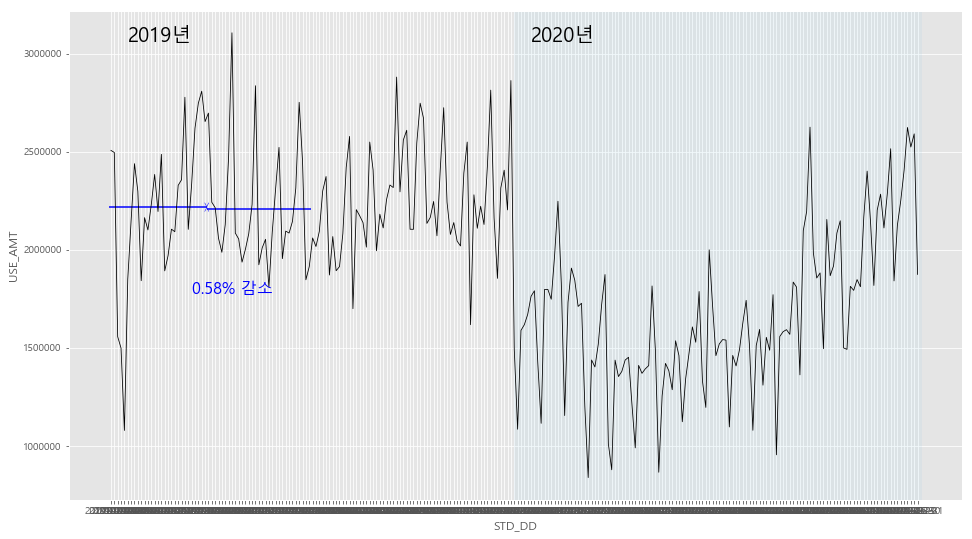

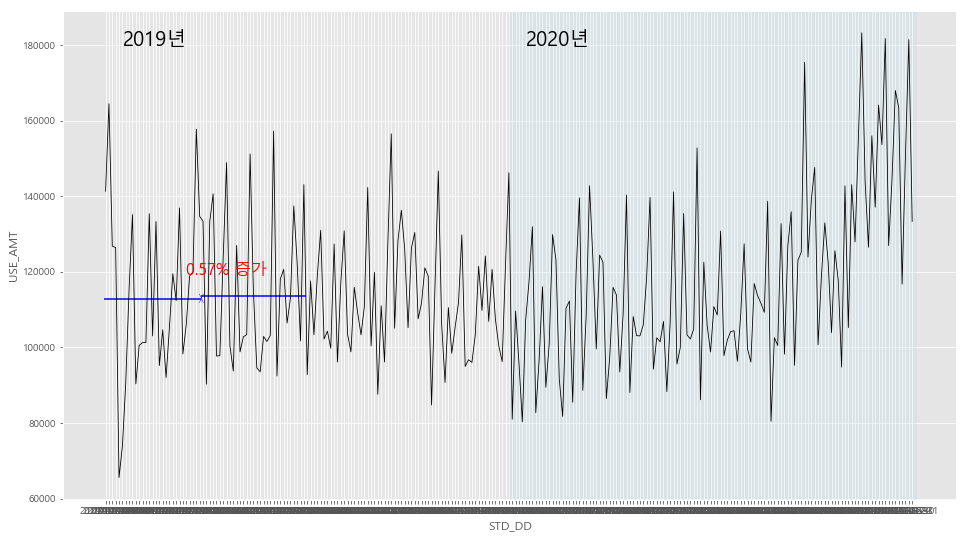

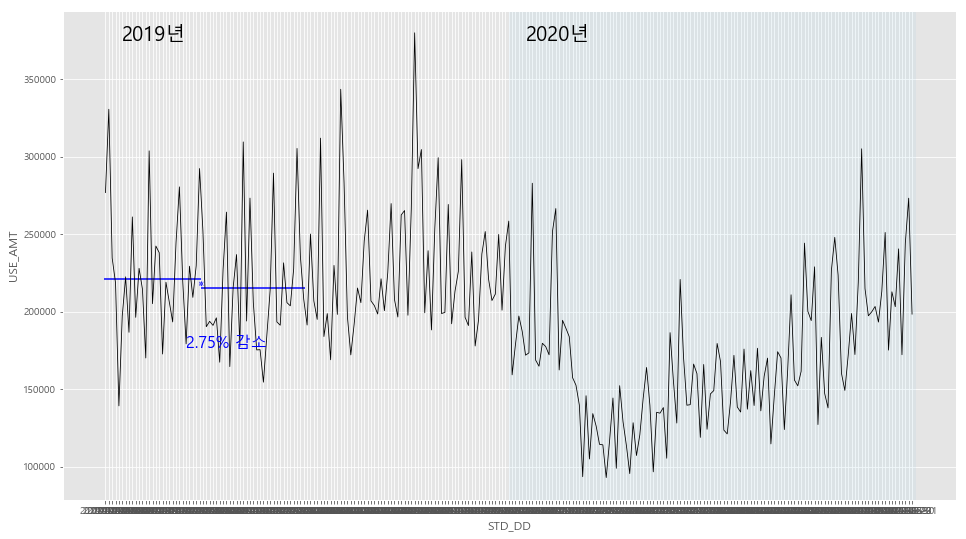

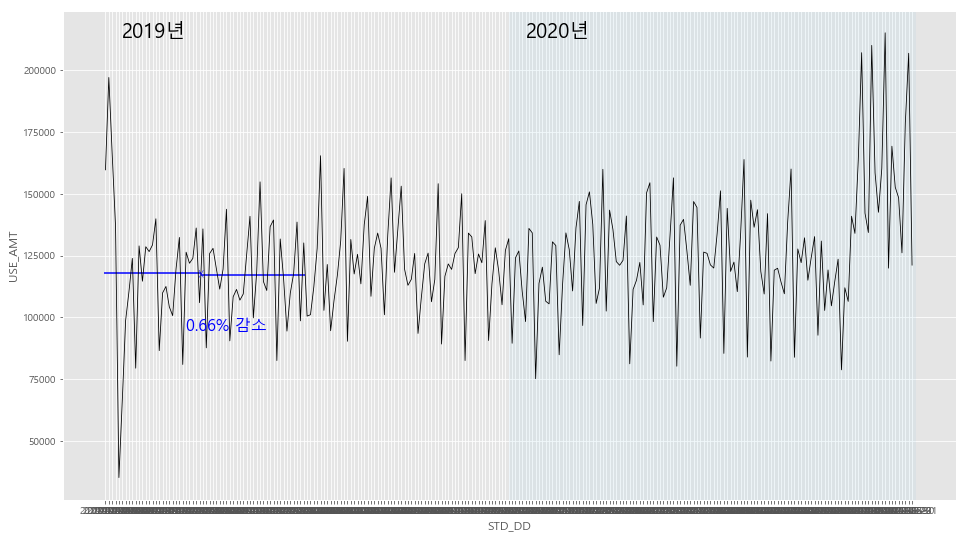

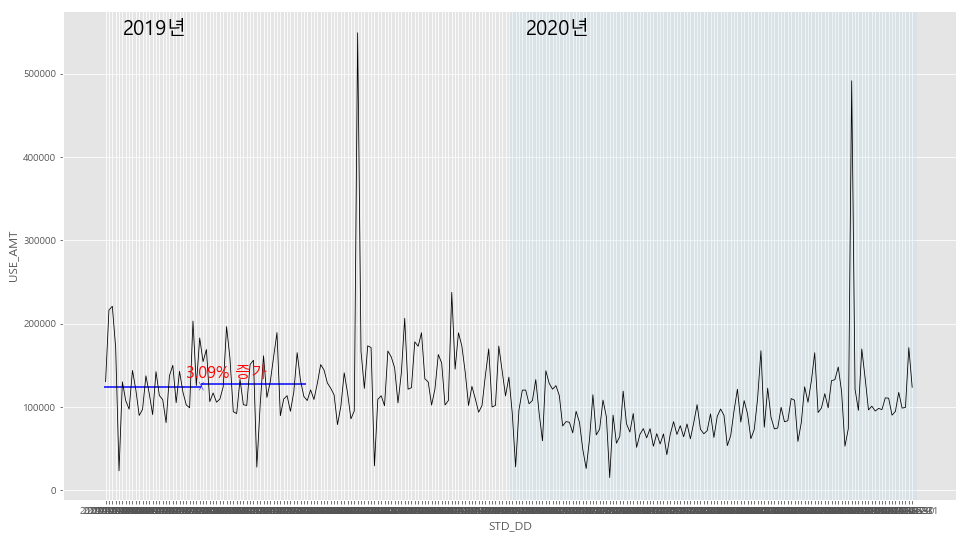

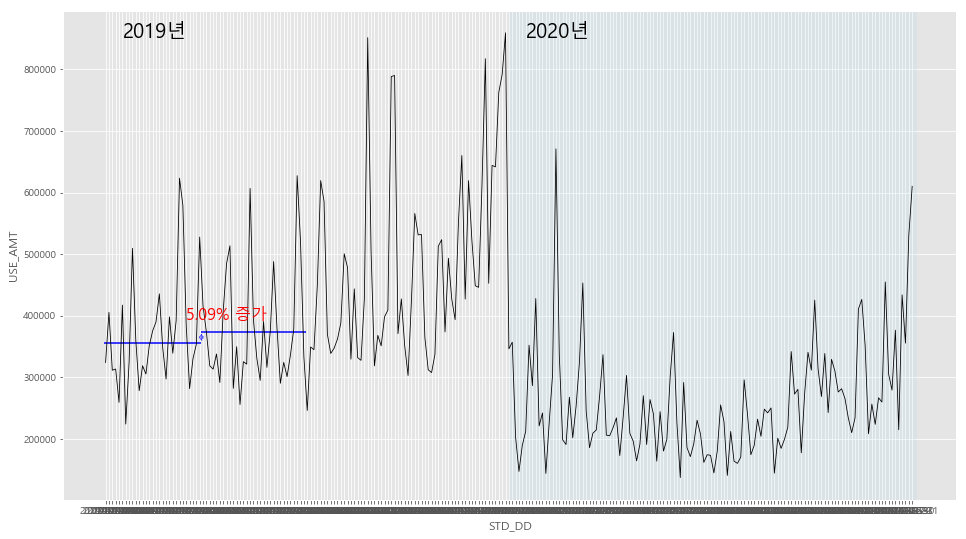

In [407]:
for dong in choices(register.HDONG_NM.unique().tolist(),k=10):
    plot_cardAMT_risk(register, dong)
    
gc.collect()

In [63]:
def get_minNmax_cardCNT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_DD'])['USE_CNT'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_DD'])['USE_CNT'].sum())
    
    return mn2020,mx2020

In [100]:
# outlier제거하는 방향으로 해봐야할듯

def risk_index_cardCNT(df,  covid_weight=.6):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2020,max2020 = get_minNmax_cardCNT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_CNT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardCNT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardCNT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardCNT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardCNT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        # cardCNT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        
        if (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days >= 6 :
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-6:min_date_index_2020+1,-1].sum()
        else:
            time_to_first = (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-time_to_first:min_date_index_2020+(7-time_to_first),-1].sum()
        cardCNT_feb_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardCNT_mar_2019 - mean_cardCNT_feb_2019)/mean_cardCNT_feb_2019
        r2 = (cardCNT_mar_2020 - cardCNT_feb_2020)/cardCNT_feb_2020
        
        # risk = (np.abs(r2-r1)/(r2-r1))*(np.sqrt((r1+1)*(r2+1))-1)
        risk = ((r2*covid_weight)-(r1*(1-covid_weight)))
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [85]:
def plot_cardCNT_risk(df, dong,):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_CNT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_CNT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_CNT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    ax.vlines(x=149, ymin=low, ymax=high)
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

In [101]:
card_risk = risk_index_cardCNT(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:10<00:00,  6.49it/s]


In [102]:
card_risk

{'고산1동': -0.19568026869542082,
 '고산2동': -0.1985380701769888,
 '고산3동': -0.11006958052930965,
 '공릉1동': -0.06261785712257861,
 '공릉2동': -0.1789238708942511,
 '광희동': -0.15438561344021262,
 '남산1동': -0.23906789875638126,
 '남산2동': -0.33901037987935473,
 '남산3동': -0.1780942122912988,
 '남산4동': -0.14590091842847175,
 '다산동': -0.040293739242796146,
 '대봉1동': -0.25924792989665674,
 '대봉2동': -0.35439549215994975,
 '대신동': -0.2744335231836138,
 '동인동': -0.2267074384281935,
 '동화동': -0.055454731276950595,
 '두산동': -0.2335066041351198,
 '만촌1동': -0.19921427404466752,
 '만촌2동': -0.2789547248597163,
 '만촌3동': -0.22665743858433968,
 '명동': -0.16832154705311517,
 '범물1동': -0.2127787931284193,
 '범물2동': -0.04670433837352249,
 '범어1동': -0.22701429972664827,
 '범어2동': -0.3552087508971815,
 '범어3동': -0.2038672732413184,
 '범어4동': -0.24035645874506303,
 '삼덕동': -0.36520508056725093,
 '상계10동': -0.1403467133661049,
 '상계1동': -0.022467923104297287,
 '상계2동': -0.16730192606953595,
 '상계3.4동': -0.006440016809189281,
 '상계5동': 0.0319046204

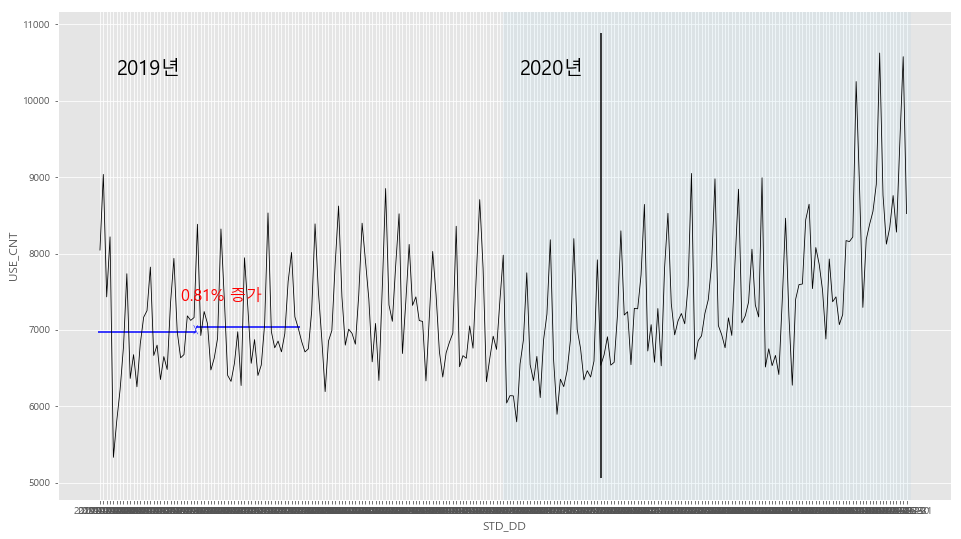

In [103]:
plot_cardCNT_risk(register, '상계5동')

In [416]:
risk_index_summ = pd.DataFrame(register.HDONG_NM.unique().tolist(), columns=['HDONG_NM'])

In [417]:
ce_fp_time = risk_index_fp(fp_time)
ce_cardAMT = risk_index_cardAMT(register)
ce_cardCNT = risk_index_cardCNT(register)

100%|███████████████████████████████████████████████████████████████████| 69/69 [00:10<00:00,  6.41it/s]


In [418]:
risk_index_summ['ce_fp_time'] = risk_index_summ.HDONG_NM.map(ce_fp_time)
risk_index_summ['ce_cardAMT'] = risk_index_summ.HDONG_NM.map(ce_cardAMT)
risk_index_summ['ce_cardCNT'] = risk_index_summ.HDONG_NM.map(ce_cardCNT)

In [422]:
risk_index_summ

HDONG_NM  ce_fp_time  ce_cardAMT  ce_cardCNT
0       동인동    0.247952    0.411289    0.222740
1       삼덕동    0.312531    0.422746    0.554240
2      성내1동    0.297617    0.424105    0.683635
3      성내2동    0.371768    0.506350    0.559178
4      성내3동    0.252392    0.751168    0.245786
..      ...         ...         ...         ...
64     상계5동    0.071146   -0.014009   -0.033032
65   상계6.7동    0.106128    0.147209    0.129079
66     상계8동    0.030929    0.041419    0.034348
67     상계9동    0.095883    0.007617   -0.016076
68    상계10동    0.100268    0.116343    0.131387

[69 rows x 4 columns]

In [424]:
with open(os.path.join(pickle_file_path, 'card_code_to_name_dict.pickle'), 'rb') as f:
        card_code_to_name_dict = pickle.load(f)

In [442]:
risk_index_summ['GU_NM'] = risk_index_summ.HDONG_NM.map({v: k for k, v in card_code_to_name_dict.get('행정동명').items()}).map(card_code_to_name_dict.get('구명'))

In [446]:
risk_index_summ['SI_NM'] = risk_index_summ.GU_NM.apply(lambda x : x.split(' ')[0])

In [447]:
risk_index_summ['GU_NM'] = risk_index_summ.GU_NM.apply(lambda x : x.split(' ')[1])

In [450]:
risk_index_summ = risk_index_summ.replace(['대구','서울'], ['대구광역시','서울특별시'])

In [452]:
risk_index_summ.to_csv("risk_index_tableau.csv", index=False)

In [453]:
risk_index_summ

HDONG_NM  ce_fp_time  ce_cardAMT  ce_cardCNT GU_NM  SI_NM
0       동인동    0.247952    0.411289    0.222740    중구  대구광역시
1       삼덕동    0.312531    0.422746    0.554240    중구  대구광역시
2      성내1동    0.297617    0.424105    0.683635    중구  대구광역시
3      성내2동    0.371768    0.506350    0.559178    중구  대구광역시
4      성내3동    0.252392    0.751168    0.245786    중구  대구광역시
..      ...         ...         ...         ...   ...    ...
64     상계5동    0.071146   -0.014009   -0.033032   노원구  서울특별시
65   상계6.7동    0.106128    0.147209    0.129079   노원구  서울특별시
66     상계8동    0.030929    0.041419    0.034348   노원구  서울특별시
67     상계9동    0.095883    0.007617   -0.016076   노원구  서울특별시
68    상계10동    0.100268    0.116343    0.131387   노원구  서울특별시

[69 rows x 6 columns]

### 업종별 Risk Index

업종별 일별 USE_CNT에 대한 RISK INDEX

In [ ]:
def get_minNmax_cardCNT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = np.argmax(df_feb_2020.groupby(['STD_DD'])['USE_CNT'].sum())
    mn2020 = np.argmin(df_mar_2020.groupby(['STD_DD'])['USE_CNT'].sum())
    
    return mn2020,mx2020

In [111]:
# outlier제거하는 방향으로 해봐야할듯

def cat_risk_index_cardCNT(df,  covid_weight=.6):
    categories = list(df.MCT_CAT_NM.unique())
    risk_by_dong = {}
    
    for cat in tqdm(categories):
        tmp_df = df.loc[df.MCT_CAT_NM==cat]
        min2020,max2020 = get_minNmax_cardCNT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_CNT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardCNT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardCNT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardCNT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardCNT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        # cardCNT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        
        if (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days >= 6 :
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-6:min_date_index_2020+1,-1].sum()
        else:
            time_to_first = (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-time_to_first:min_date_index_2020+(7-time_to_first),-1].sum()
        cardCNT_feb_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardCNT_mar_2019 - mean_cardCNT_feb_2019)/mean_cardCNT_feb_2019
        r2 = (cardCNT_mar_2020 - cardCNT_feb_2020)/cardCNT_feb_2020
        
        # risk = (np.abs(r2-r1)/(r2-r1))*(np.sqrt((r1+1)*(r2+1))-1)
        risk = ((r2*covid_weight)-(r1*(1-covid_weight)))
        
        risk_by_cat[cat] = risk
        
    return risk_by_cat

In [169]:
def plot_cat_cardCNT_risk(df, cat, risk_index_dict=None):
    if risk_index_dict != None:
        risk = risk_index_dict.get(cat)
    tmp_df = df.loc[df.MCT_CAT_NM==cat].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    # labels = list(tmp_df.STD_DD.unique())
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_CNT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_CNT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_CNT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    # ax.vlines(x=149, ymin=low, ymax=high) # 3월1일 기준선
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
     
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)
    if risk_index_dict != None:
        ax.annotate(s=f'Risk Index : {risk}', xy =(125,high*0.85), fontsize=16)
    
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False
    )
    ax.set_title(f'{cat}', fontsize=18)
    
    plt.show()

In [146]:
cat_risk = cat_risk_index_cardCNT(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


In [173]:
# plot_cat_cardCNT_risk(register, '가구')

In [371]:
resilience_index(register)

{'가구': 1.0287150131295388,
 '가전': 0.7224060945391957,
 '광학제품': 0.723871156030384,
 '레저업소': 0.7944452638593448,
 '레저용품': 0.8108791657870028,
 '문화취미': 0.5329776535025803,
 '보건위생': 0.6367539152113617,
 '사무통신': 0.5954076852935215,
 '서적문구': 0.6093663618052783,
 '수리서비스': 0.941393186434831,
 '숙박': 0.637398092583437,
 '신변잡화': 0.5971605794610834,
 '연료판매': 0.7417572887938971,
 '요식업소': 0.8321554849875533,
 '유통업': 0.8098834835162545,
 '음료식품': 0.9398025565241882,
 '의료기관': 0.9889881465662097,
 '의복': 0.5472205603289868,
 '자동차 정비': 0.6373354468688075,
 '자동차판매': 1.1177057645563346,
 '전기': 1.2274524572398322,
 '주방용구': 1.0713768440678313,
 '직물': 0.9871325217291868}

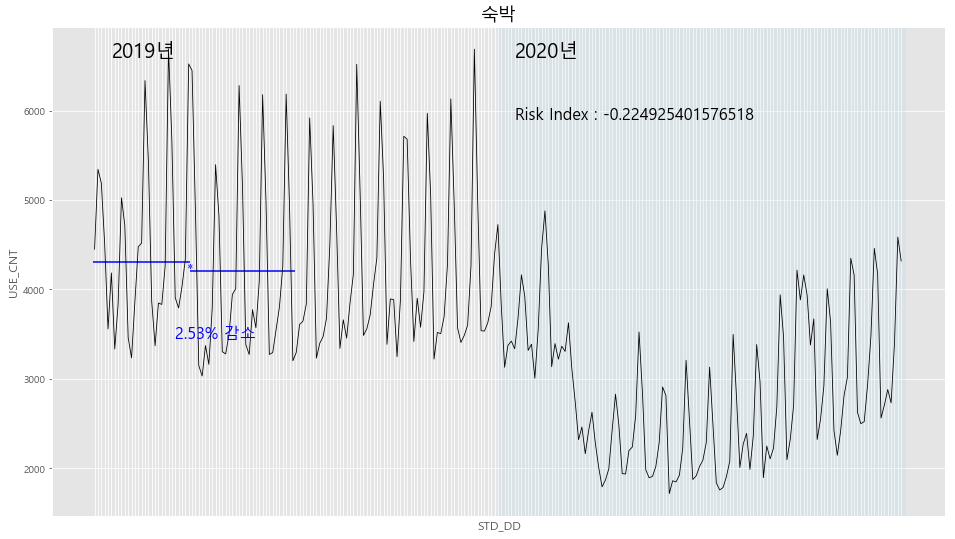

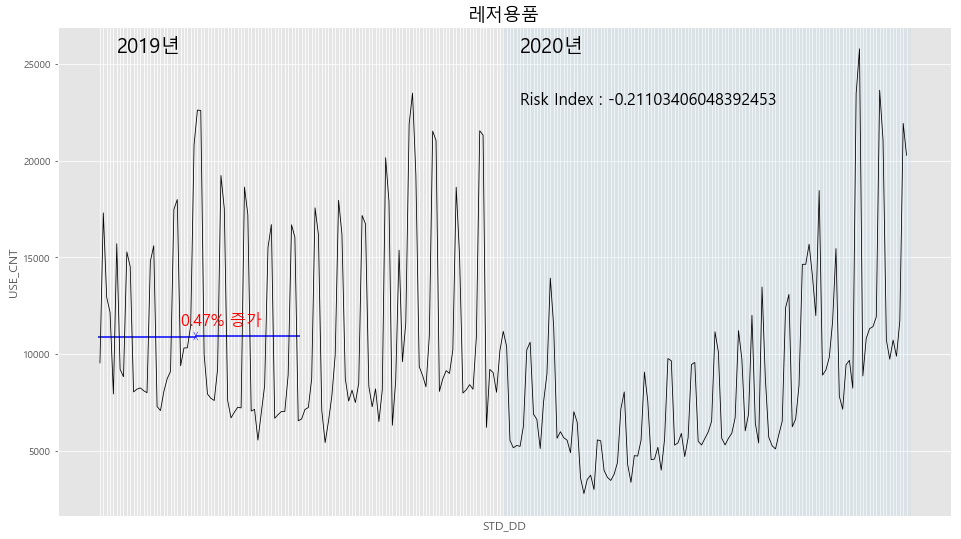

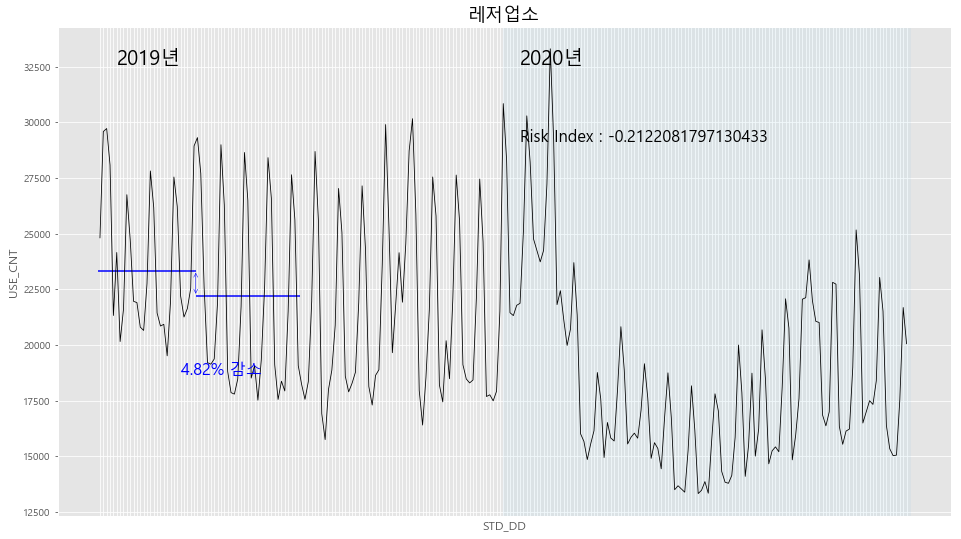

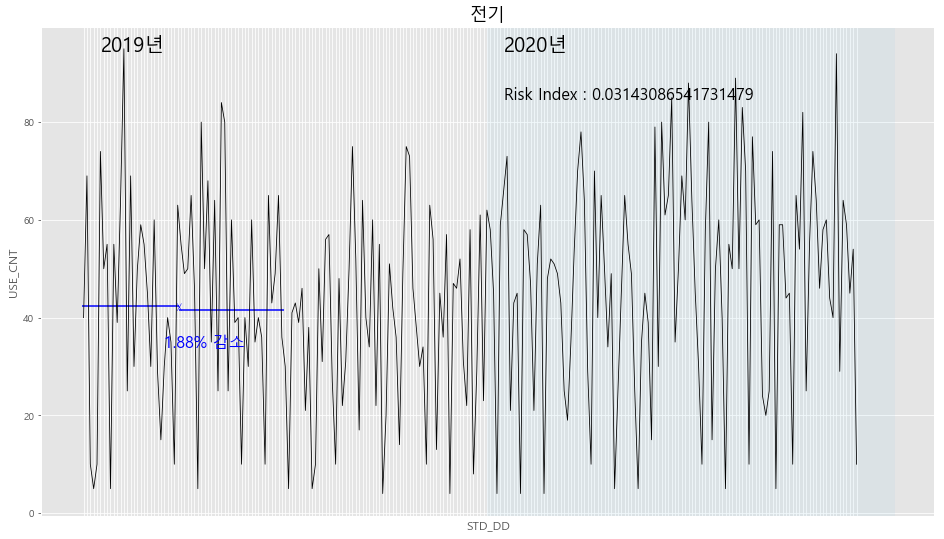

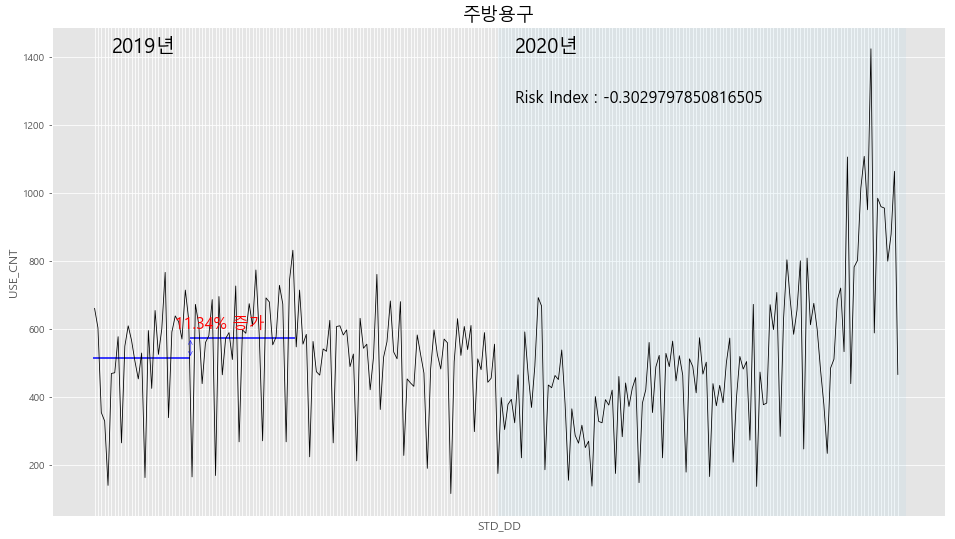

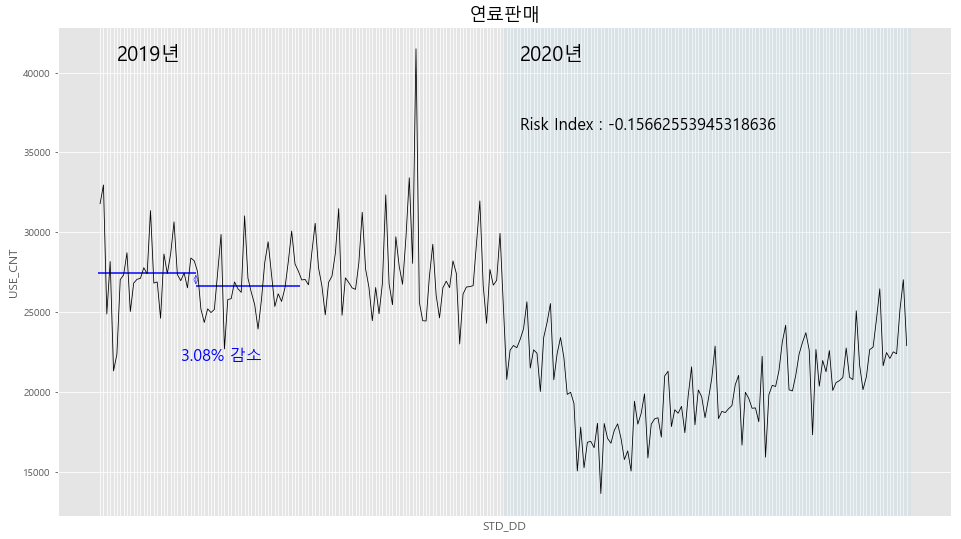

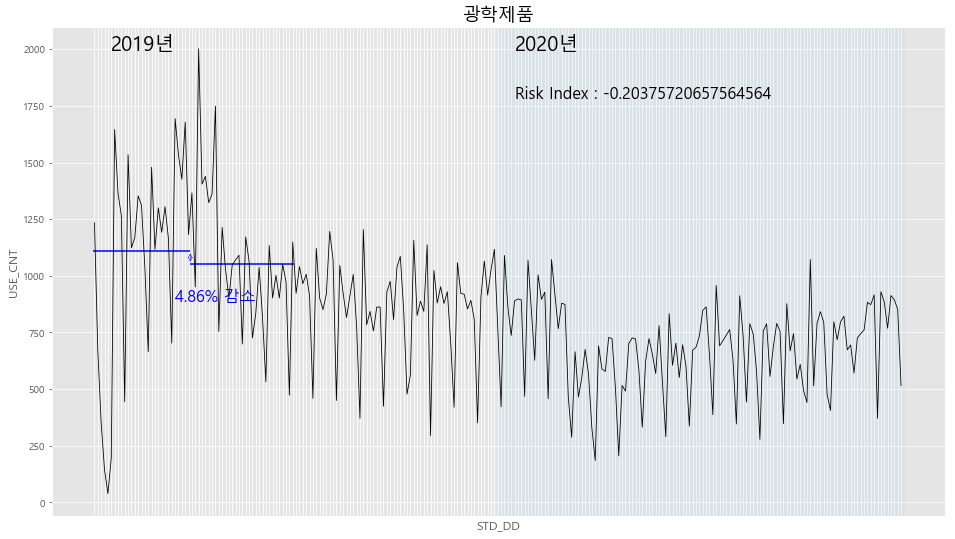

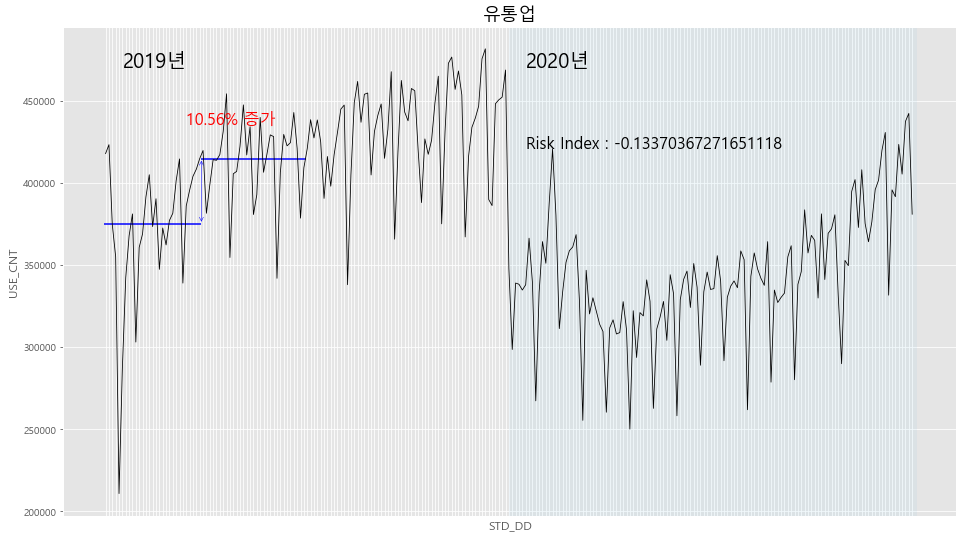

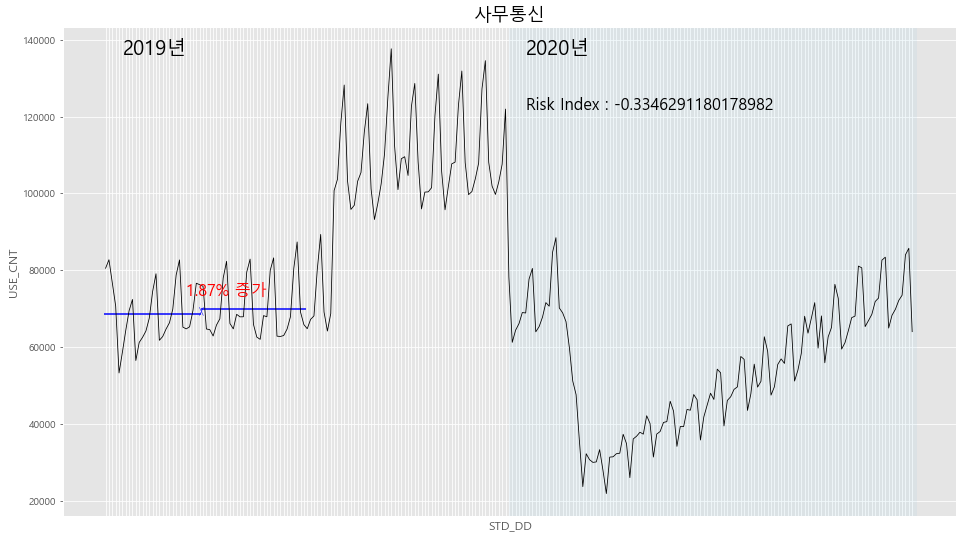

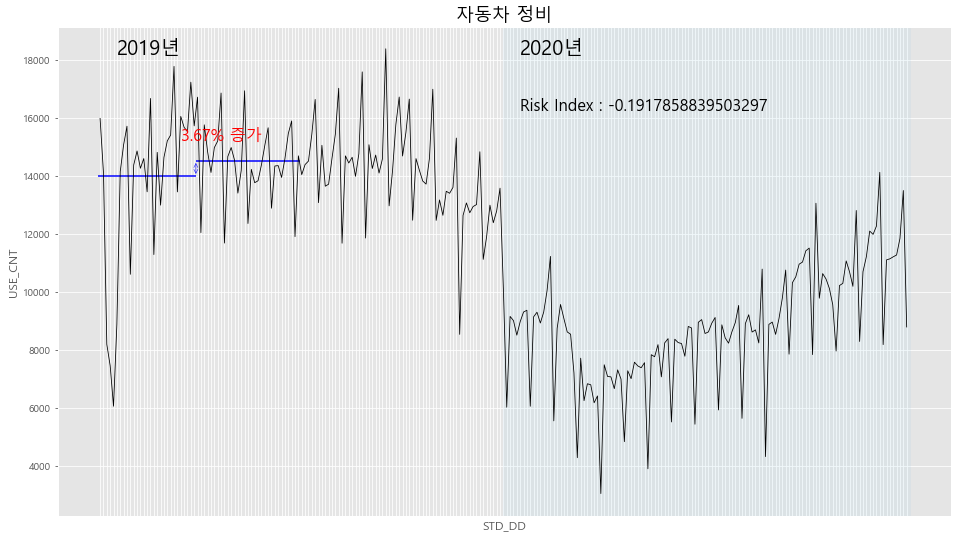

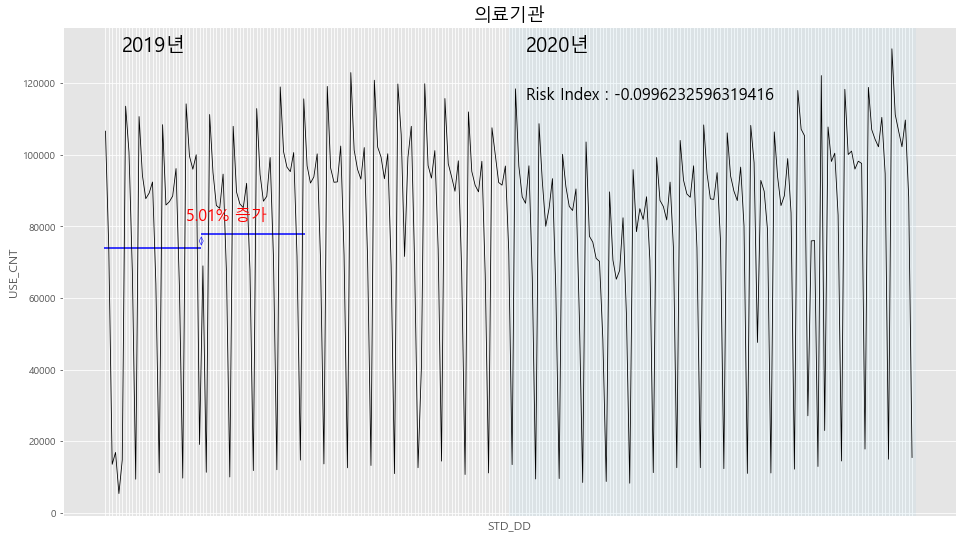

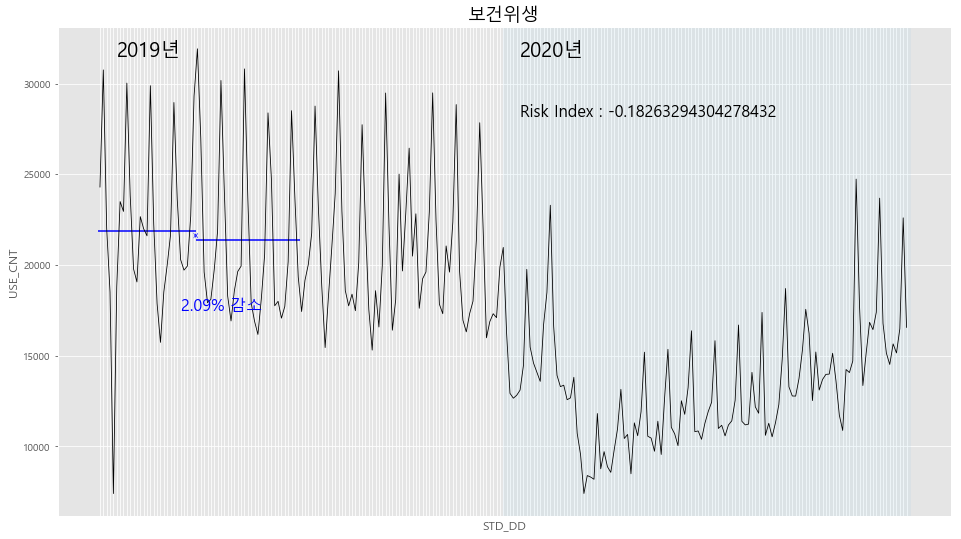

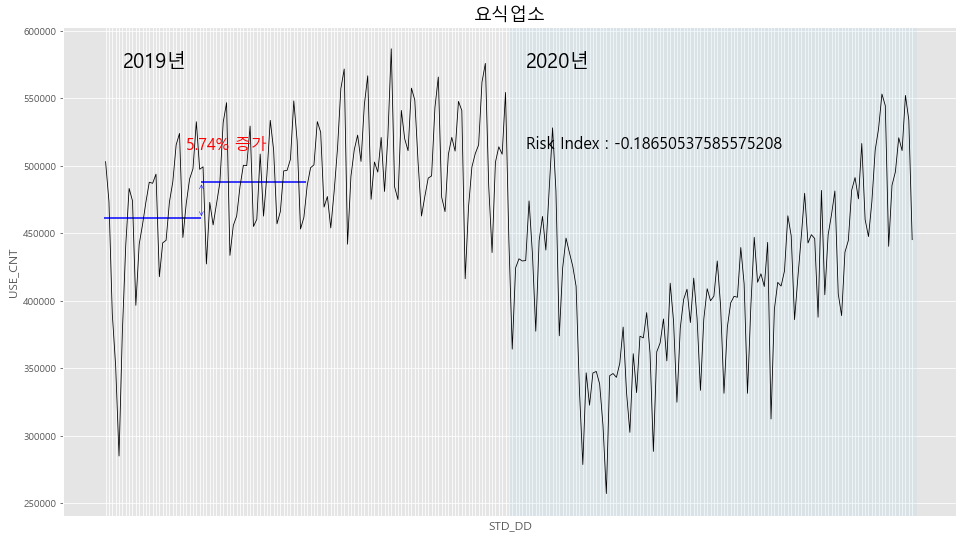

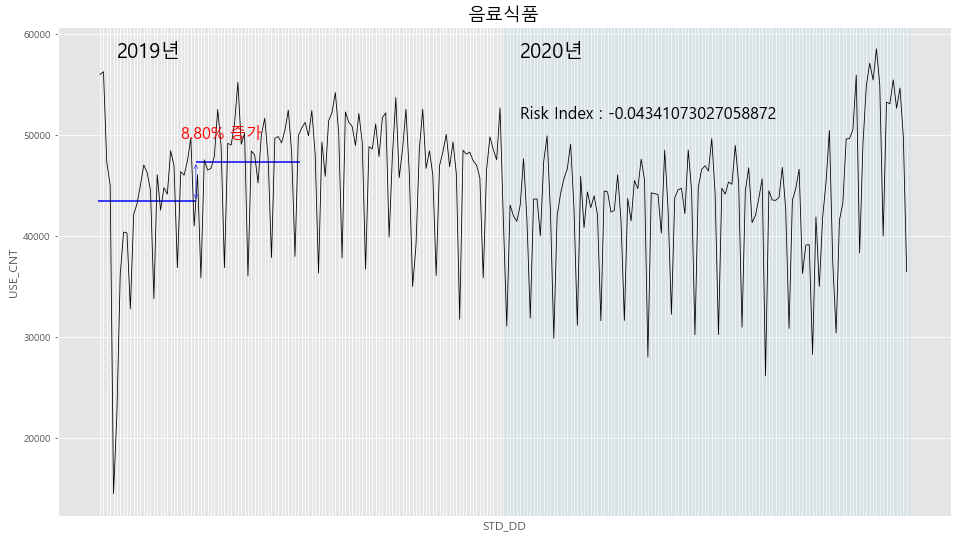

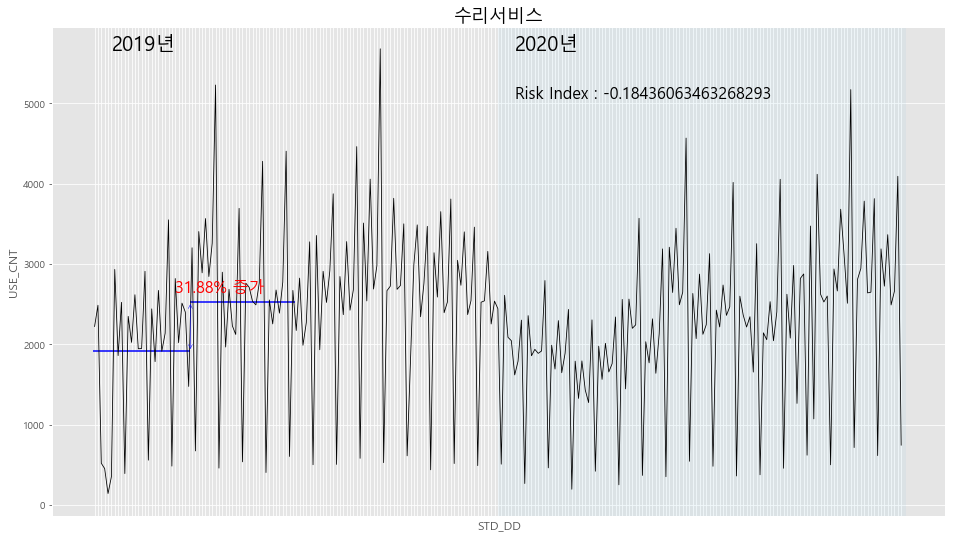

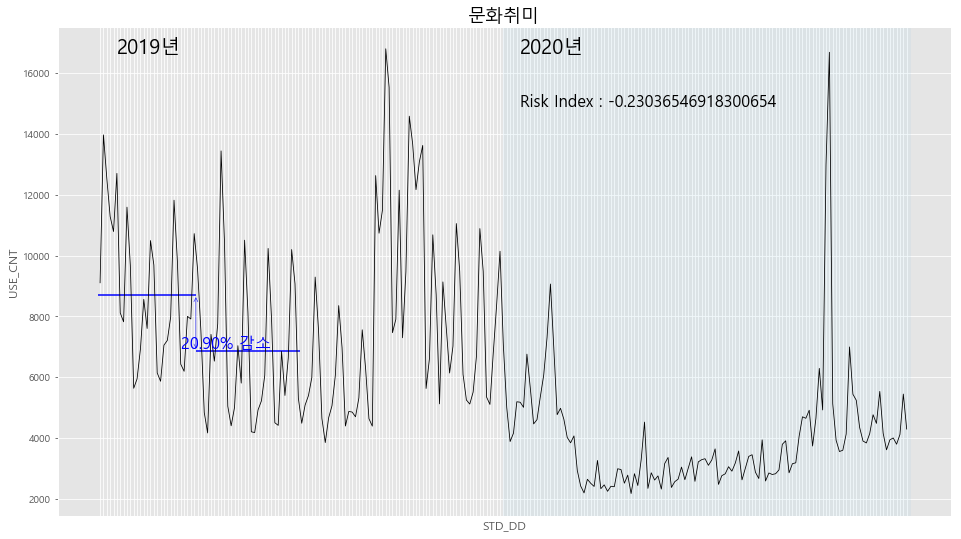

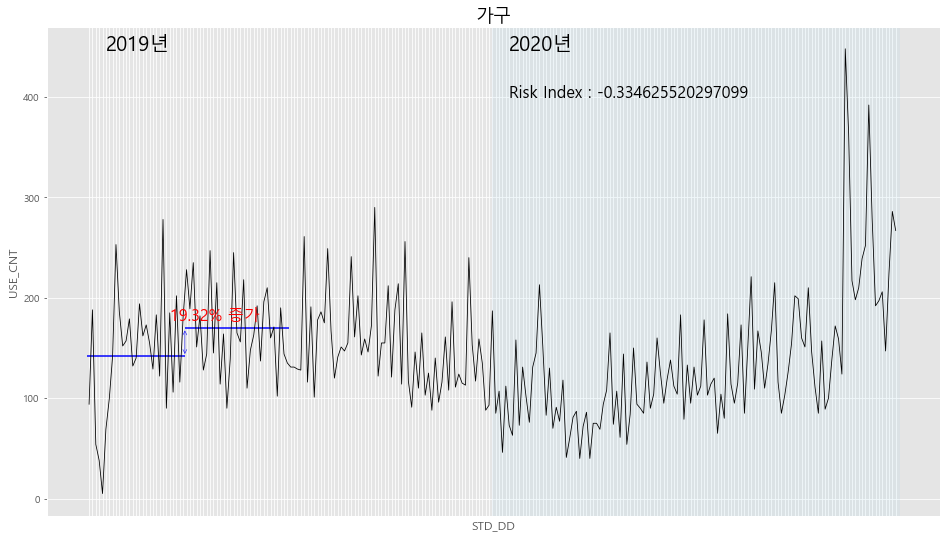

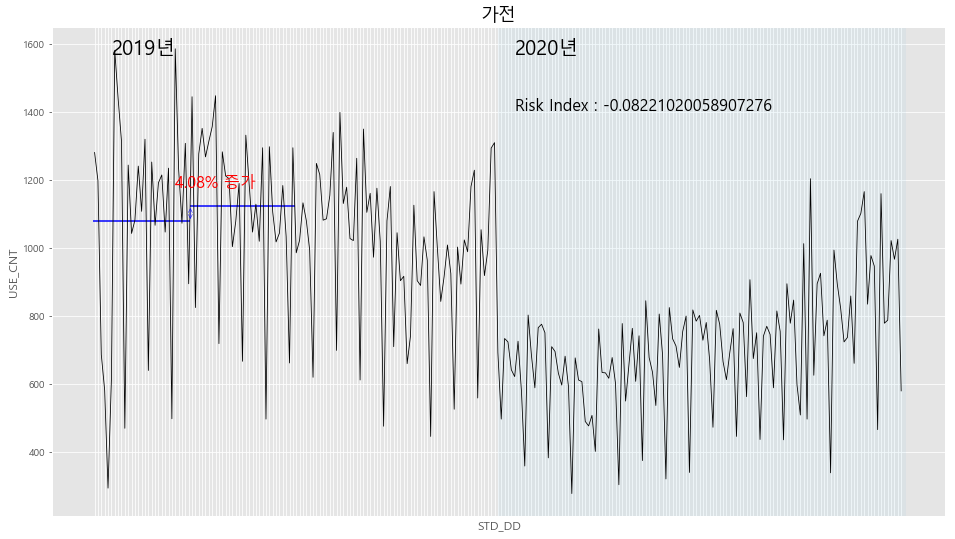

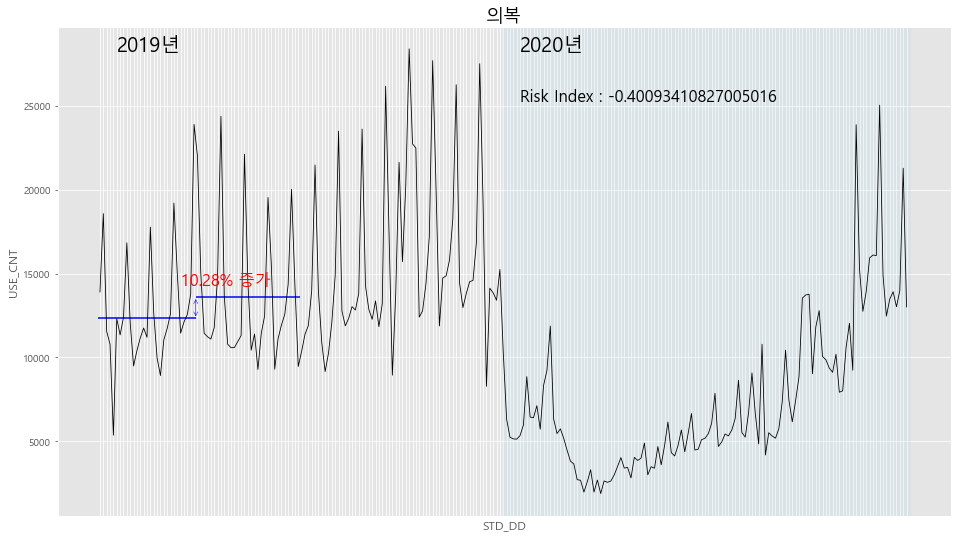

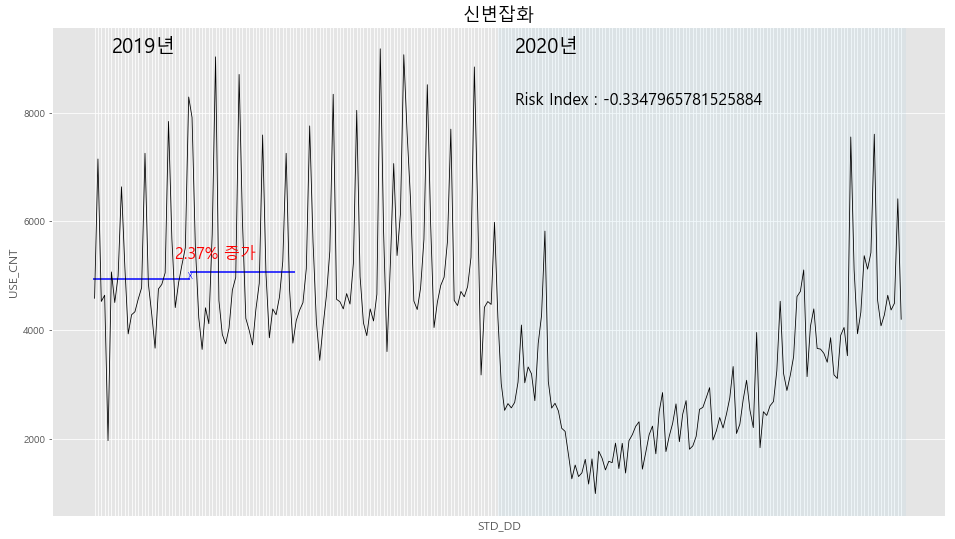

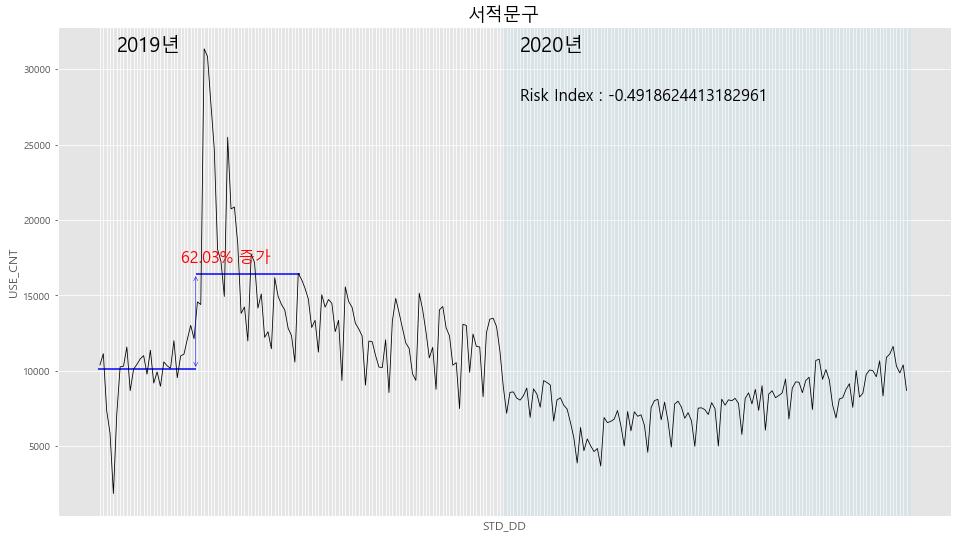

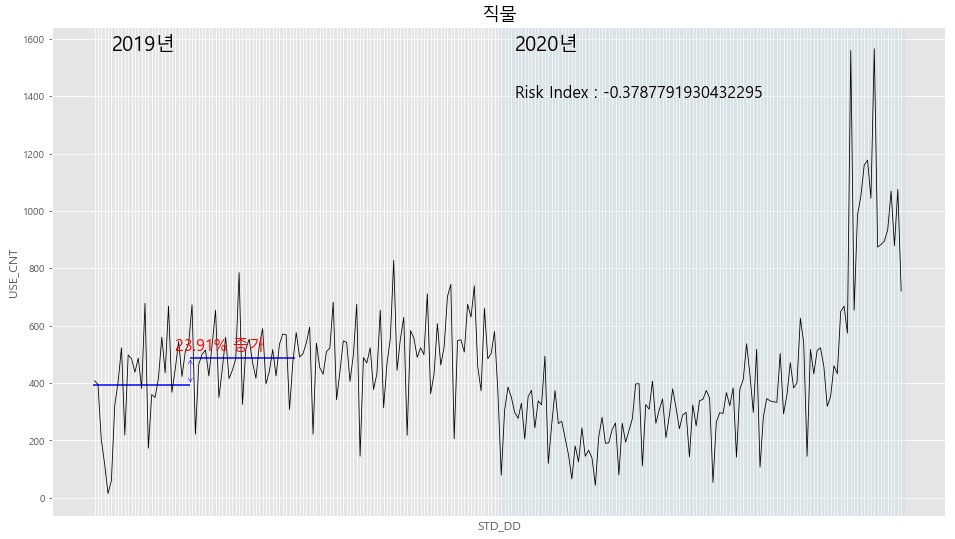

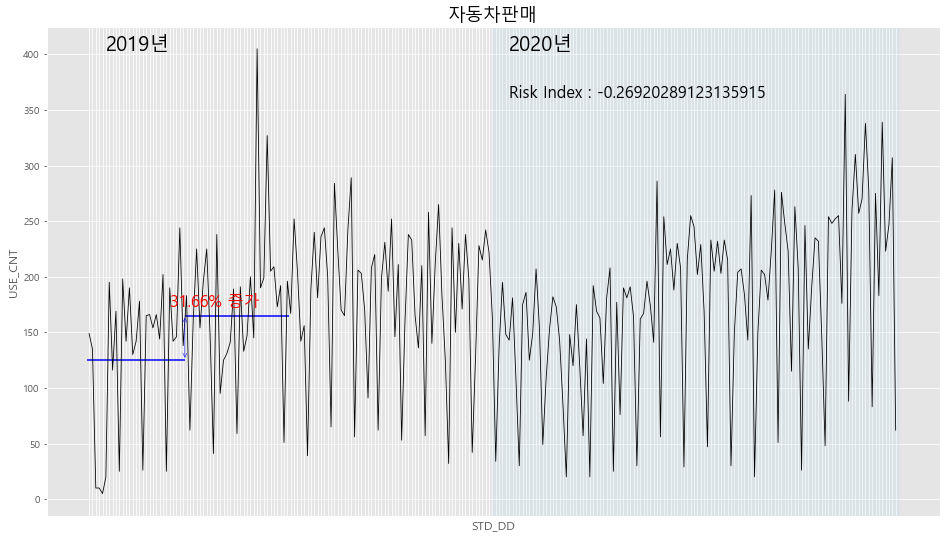

In [172]:
for cat in register.MCT_CAT_NM.unique():
    plot_cat_cardCNT_risk(register, cat, cat_risk)

### 회복탄력성 ( Resilience )  

In [ ]:
tmp = register_2019.groupby(['MCT_CAT_NM','weekofyear'])['USE_CNT'].sum().\
        reset_index(name='USE_CNT_2019').\
        merge(
                register_2020.groupby(['MCT_CAT_NM','weekofyear'])['USE_CNT'].sum().\
                reset_index(name='USE_CNT_2020')
        ).eval('USE_CNT_RATE = (USE_CNT_2020/USE_CNT_2019)').\
        query('weekofyear >=9 & weekofyear <= 21')

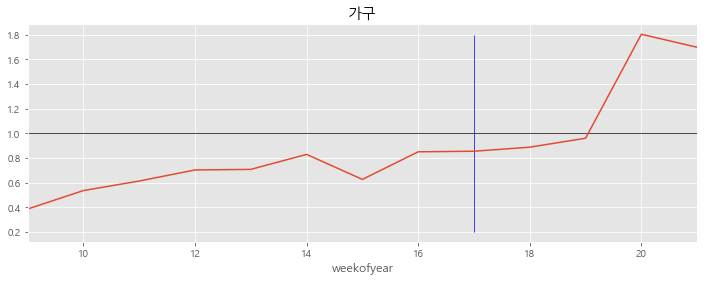

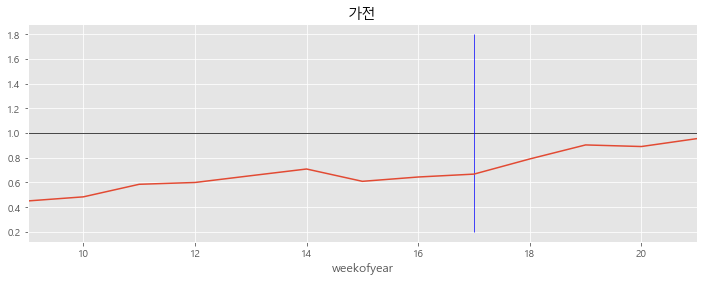

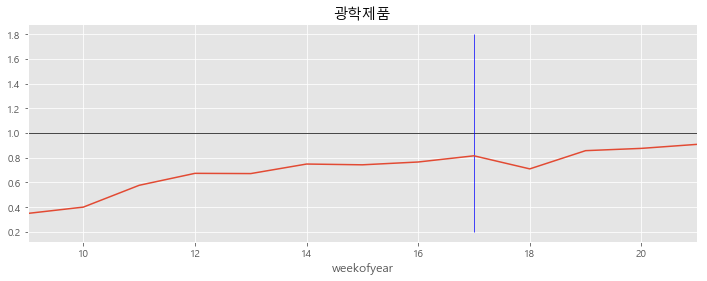

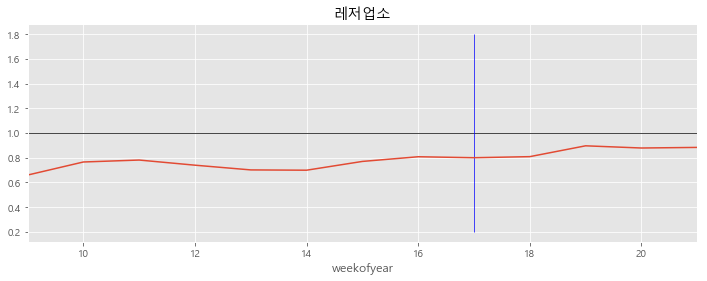

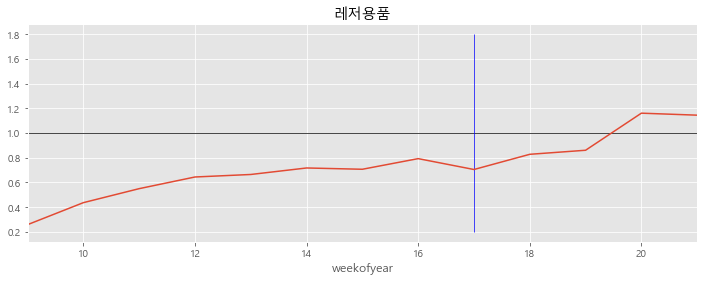

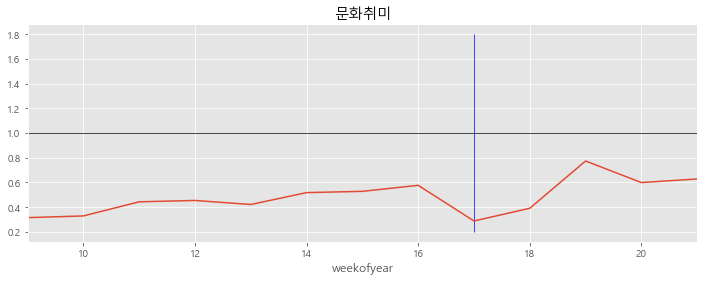

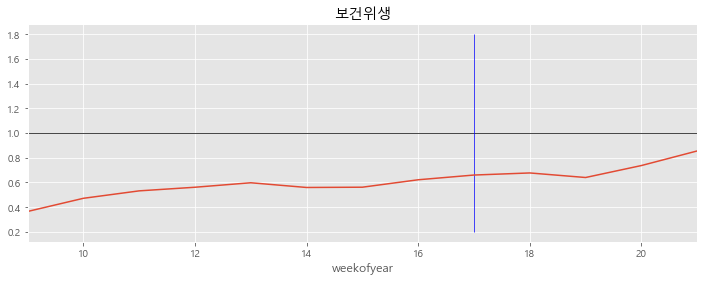

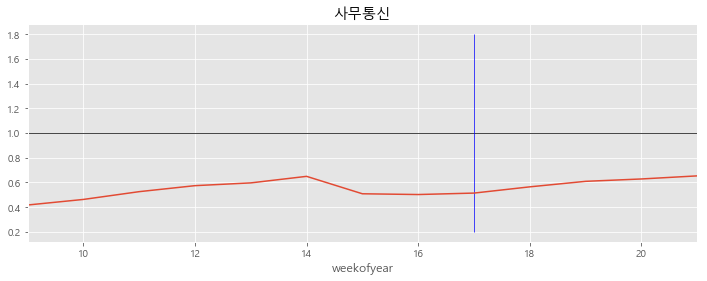

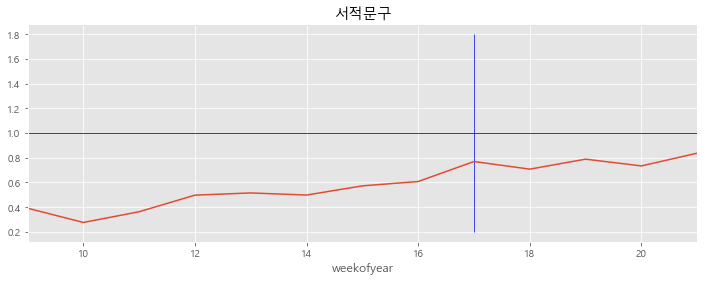

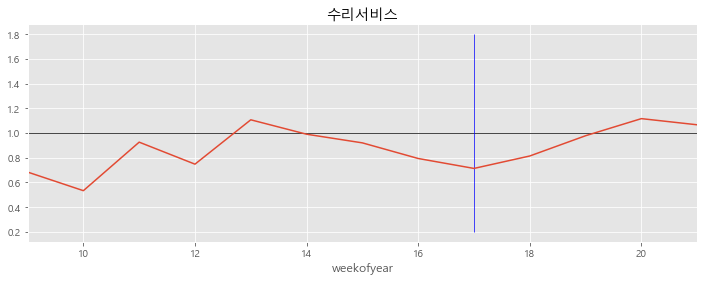

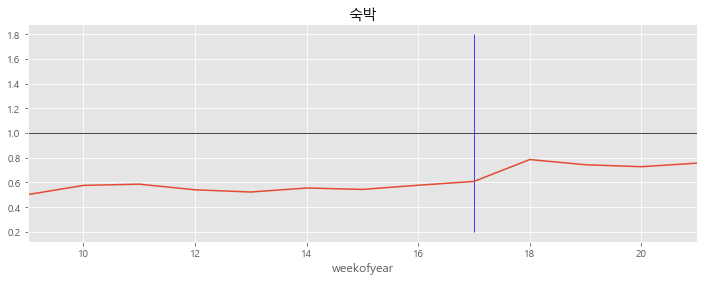

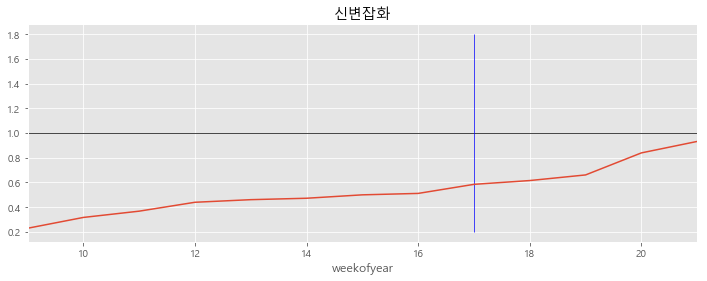

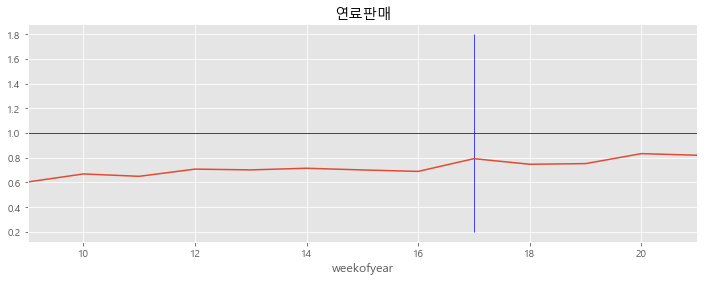

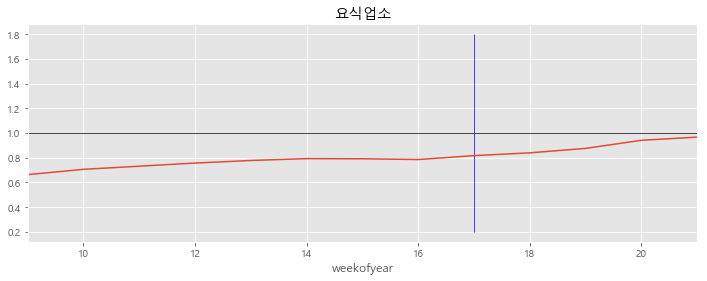

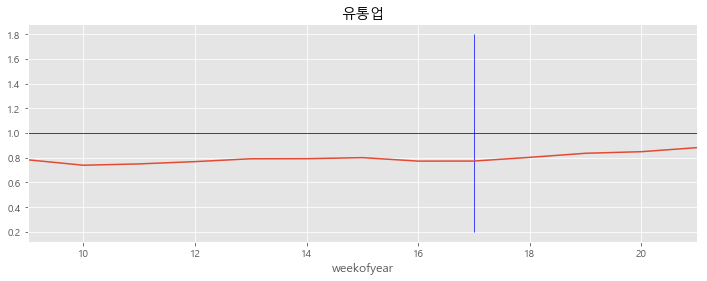

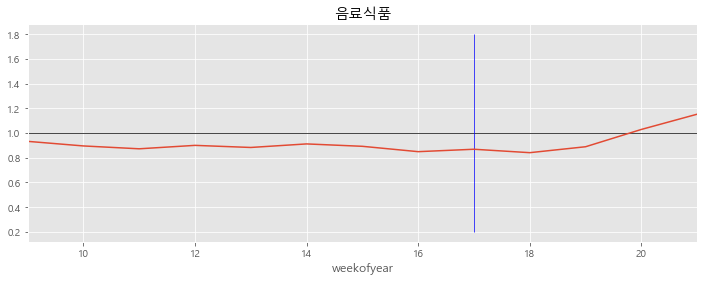

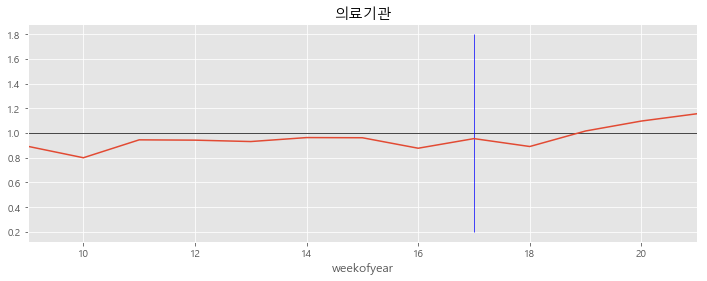

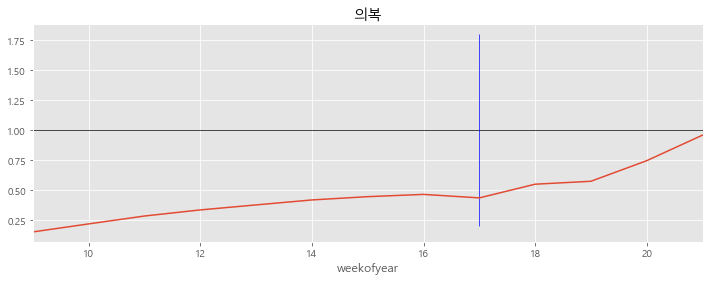

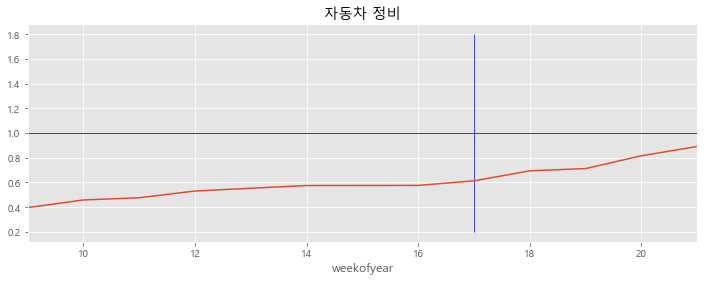

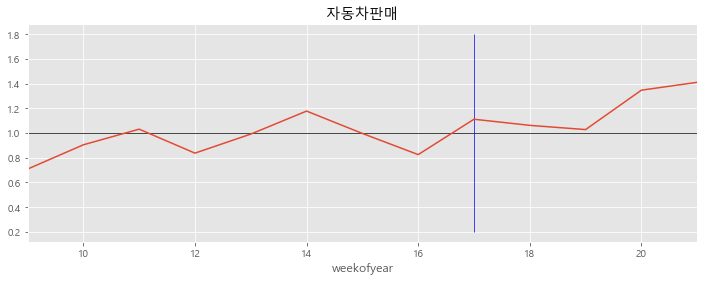

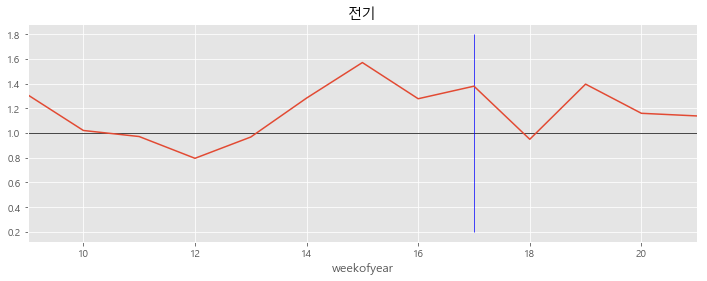

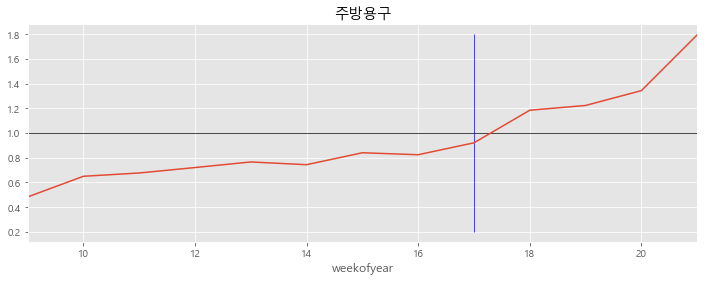

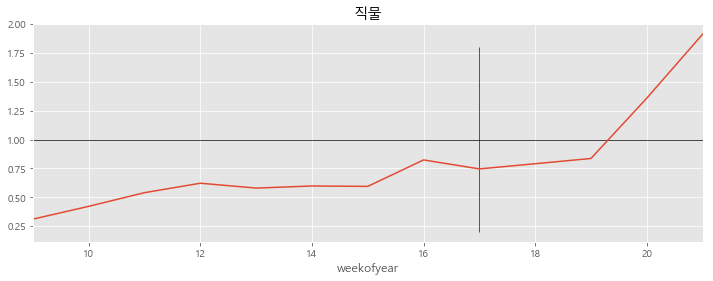

In [565]:
for cat in tmp.MCT_CAT_NM.unique():
    tmp.loc[tmp.MCT_CAT_NM==cat].set_index('weekofyear').USE_CNT_RATE.plot(figsize=(12,4))
    plt.title(f'{cat}')
    plt.hlines(y=1, xmin= 9, xmax=21, color='k',linewidth=.7)
    plt.vlines(x=17, ymin=.2, ymax=1.8, color='b', linewidth=.7)
    plt.show()

$Resilence Index = {\sum_{i=1}^N r_i \cdot t_i \over N}$  
$ r_i :$ 전년 동주 대비 비율  
$ t_i :$ 동년 전주 대비 비율
  
  
$Modification Version$  
$Resilence Index = {\alpha \sum_{k=1}^N (N-k+1) \cdot r_k \over \sum_{k=1}^N k} $  
$ r_i :$ 전주 대비 비율  
$\alpha :$ 회복기간 마지막주 기준 전년대비 비율

In [ ]:
def WTW_ratio(df, contain_may=False, value='USE_CNT'):
    def compare_(sub_df,contain_may=contain_may):
        if contain_may:
            pre_use_cnt = sub_df.USE_CNT.values
            use_cnt = sub_df.shift().fillna(method='bfill').USE_CNT.values
        else:
            pre_use_cnt = sub_df.iloc[:-4].USE_CNT.values
            use_cnt = sub_df.iloc[:-4].shift().fillna(method='bfill').USE_CNT.values
        return np.array(np.divide(pre_use_cnt,use_cnt))
    
    
    tmp = df.query('year==2020 & weekofyear>=9 & weekofyear<=21').reset_index(drop=True)
    
    res = tmp.groupby(['MCT_CAT_NM','weekofyear'])['USE_CNT'].sum().\
            reset_index().\
            groupby('MCT_CAT_NM').\
            apply(compare_).\
            reset_index(name='ratio_wtw').\
            set_index('MCT_CAT_NM')
    
    return res    

In [581]:
def WTW_ratio(df, contain_may=False, value='USE_CNT'):
    def compare_(sub_df,contain_may=contain_may):
        if contain_may:
            pre_use_cnt = sub_df[value].values
            use_cnt = sub_df.shift().fillna(method='bfill')[value].values
        else:
            pre_use_cnt = sub_df.iloc[:-3][value].values
            use_cnt = sub_df.iloc[:-3].shift().fillna(method='bfill')[value].values
        return np.array(np.divide(pre_use_cnt,use_cnt))
    
    
    tmp = df.query('year==2020 & weekofyear>=9 & weekofyear<=21').reset_index(drop=True)
    
    res = tmp.groupby(['MCT_CAT_NM','weekofyear'])[value].sum().\
            reset_index().\
            groupby('MCT_CAT_NM').\
            apply(compare_).\
            reset_index(name='ratio_wtw').\
            set_index('MCT_CAT_NM')
    
    return res    

In [537]:
def YOY_ratio(df):
    tmp_2019 = df.query('year==2019 & weekofyear>=9 & weekofyear<=21').reset_index(drop=True)
    tmp_2020 = df.query('year==2020 & weekofyear>=9 & weekofyear<=21').reset_index(drop=True)
    
    total_yoy_rate = tmp_2019.groupby(['MCT_CAT_NM','weekofyear'])['USE_CNT'].sum().\
        reset_index(name='USE_CNT_2019').\
        merge(
                tmp_2020.groupby(['MCT_CAT_NM','weekofyear'])['USE_CNT'].sum().\
                reset_index(name='USE_CNT_2020')
        ).eval('USE_CNT_RATE = (USE_CNT_2020/USE_CNT_2019)')
    
    cat_yoy_rate = total_yoy_rate.groupby(['MCT_CAT_NM'])['USE_CNT_RATE'].apply(lambda x : np.array(x)).reset_index(name='ratio_yoy')
    
    return cat_yoy_rate

In [610]:
def resilience_index(df, value='USE_CNT'):
    #기간 9주차이후 / 회복이 시작된 주차
    
    # 가중이동평균
    def weighted_moving_average(array):
        N = len(array)
        weight = np.array(range(1,N+1))
        return np.sum(array*weight)/np.sum(weight)
    
    # 가중이동편균_reversed weight
    # 코로나 확산이후 얼마나 빠르게 회복했는가를 중점으로 보기위해 코로나 확산시기에 가까울수록 가중치를 높게 설정함
    def weighted_moving_average_r(array):
        N = len(array)
        weight = np.array(range(N,0,-1))
        return np.sum(array*weight)/np.sum(weight)
    
    
    resilience_index = WTW_ratio(df, value=value)
    resilience_index['resilience_index'] = resilience_index['ratio_wtw'].apply(weighted_moving_average_r)
    last_week_index = len(resilience_index['ratio_wtw'][0])-1

    resilience_index = resilience_index.drop('ratio_wtw', axis=1)
    
    # 코로나 확산이후 얼마나 많이 회복했는가를 고려하기 위해 전년 동주대비 비율을 구하고 영향력을 조금 줄이기 위해 제곱근을 사용
    yoy_ratio = YOY_ratio(df)
    
    resilience_index['resilience_index'] = np.multiply(resilience_index['resilience_index'].values,
                                                       np.sqrt(yoy_ratio.ratio_yoy.apply(lambda x : x[last_week_index]).values))
    
    #return resilience_index
    return resilience_index.to_dict().get('resilience_index')

In [611]:
resilience_index(register)

{'가구': 1.0464020874343016,
 '가전': 0.9242245657340841,
 '광학제품': 0.879851798214195,
 '레저업소': 0.9023384324073337,
 '레저용품': 1.0039505829658169,
 '문화취미': 0.6460411325179384,
 '보건위생': 0.8663652253298587,
 '사무통신': 0.8092756529651167,
 '서적문구': 0.9040880109616918,
 '수리서비스': 0.975482426734196,
 '숙박': 0.8894328233086604,
 '신변잡화': 0.8625928420906922,
 '연료판매': 0.8879388703167412,
 '요식업소': 0.9445697370883259,
 '유통업': 0.9027462274659789,
 '음료식품': 0.9195118581720203,
 '의료기관': 0.9700794409954254,
 '의복': 0.8494938122786796,
 '자동차 정비': 0.8729237455334451,
 '자동차판매': 1.117828493381126,
 '전기': 1.008460101433821,
 '주방용구': 1.1838289504370179,
 '직물': 1.010723429755006}

In [386]:
"""
def resilience_index(df, alpha=.7, beta=.1):
    #기간 9주차이후 / 회복이 시작된 주차
    ratio_yoy = YOY_ratio(df)
    ratio_yoy['ratio_yoy_plus_alpha'] = ratio_yoy.ratio_yoy + alpha
    
    ratio_wtw = WTW_ratio(df)
    ratio_wtw['ratio_wtw_minus_beta'] = ratio_wtw.ratio_wtw - beta
    
    resilience_index = ratio_yoy.merge(ratio_wtw).\
        eval('ratio_mul = ratio_wtw_minus_beta*ratio_yoy_plus_alpha').\
        set_index('MCT_CAT_NM').ratio_mul.\
        apply(lambda x : sum(x)/len(x))
    return resilience_index
"""

In [504]:
resilience_index(register)

{'가구': 1.1150435755409358,
 '가전': 1.0409766925392026,
 '광학제품': 1.047865944446013,
 '레저업소': 0.999135243838384,
 '레저용품': 1.0991522894490373,
 '문화취미': 1.028067505519006,
 '보건위생': 1.0532724484541218,
 '사무통신': 1.0760654137035652,
 '서적문구': 1.076711366966638,
 '수리서비스': 1.0864784050070577,
 '숙박': 0.9959060409224827,
 '신변잡화': 1.0962457618602812,
 '연료판매': 1.0267024354555196,
 '요식업소': 1.0305311128384458,
 '유통업': 1.005759834815518,
 '음료식품': 1.0039704513085856,
 '의료기관': 1.0300366599990238,
 '의복': 1.1388080442759405,
 '자동차 정비': 1.0455089146398286,
 '자동차판매': 1.0891231670984258,
 '전기': 1.0379722125985664,
 '주방용구': 1.0862334888714564,
 '직물': 1.140295044083044}

In [387]:
# resilience_index with YOY rate
resilience_index(register)

{'가구': 1.6566282610322198,
 '가전': 1.315124809886072,
 '광학제품': 1.3087971596432681,
 '레저업소': 1.3544111487426054,
 '레저용품': 1.4449980430095446,
 '문화취미': 1.1675674632162194,
 '보건위생': 1.243207975899223,
 '사무통신': 1.2210967142950737,
 '서적문구': 1.2200840536589952,
 '수리서비스': 1.527658976004246,
 '숙박': 1.2241515714849156,
 '신변잡화': 1.2515247483105019,
 '연료판매': 1.317785543201133,
 '요식업소': 1.4057051013536397,
 '유통업': 1.372100884450373,
 '음료식품': 1.4922077939279115,
 '의료기관': 1.5447012950211183,
 '의복': 1.2471415546717888,
 '자동차 정비': 1.2420041295626507,
 '자동차판매': 1.6963070924489183,
 '전기': 1.7617741315862965,
 '주방용구': 1.686553099476993,
 '직물': 1.6708110687272346}